# dataset


In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
song_dataset_path = "/content/drive/MyDrive/spotify_songs.csv"
emo_dataset_path = "/content/drive/MyDrive/emotion_label.csv"
user_dataset_path = "/content/drive/MyDrive/user.csv"

song_df = pd.read_csv(song_dataset_path)
emotion_df = pd.read_csv(emo_dataset_path)
user_df = pd.read_csv(user_dataset_path)

Mounted at /content/drive


In [ ]:
emotion_df['uri_id'] = emotion_df['uri'].apply(lambda x: x.split(':')[-1])
# Filter only required emotion columns
emo_small = emotion_df[['uri_id', 'spec_rate', 'labels']]

# Merge on track_id (song_df) and uri_id (emo_df)
merged_df = pd.merge(
    song_df,
    emo_small,
    left_on='track_id',
    right_on='uri_id',
    how='inner'
)

print("Total matched tracks:", merged_df.shape[0])

# Save final dataset
output_path = "/content/drive/MyDrive/matched_songs.csv"
merged_df.to_csv(output_path, index=False)

print("Saved successfully to:", output_path)

Total matched tracks: 6012
Saved successfully to: /content/drive/MyDrive/matched_songs.csv


In [ ]:
merged_df.columns

In [ ]:
merged_df['track_album_release_date'] = pd.to_datetime(
    merged_df['track_album_release_date'], errors='coerce'
)

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemm = WordNetLemmatizer()

def clean_lyrics(text):
    text = str(text).lower()                                # lowercase
    text = re.sub(r'<.*?>', '', text)                       # remove HTML
    text = re.sub(r'[^a-zA-Z0-9\s\']', '', text)            # remove special char
    text = re.sub(r'\s+', ' ', text).strip()                # whitespace cleanup
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)              # reduce lengthening
    words = [w for w in text.split() if w not in stop_words]# remove stopwords
    #words = [lemm.lemmatize(w) for w in words]              # lemmatization
    return " ".join(words)

merged_df['lyrics'] = merged_df['lyrics'].apply(clean_lyrics)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
scale_cols = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms','spec_rate'
]

scaler = MinMaxScaler()
merged_df[scale_cols] = scaler.fit_transform(merged_df[scale_cols])


In [ ]:
%pip install faiss-cpu sentence-transformers numpy pandas scikit-learn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 87.5 MB/s eta 0:00:00


In [ ]:
!pip install langchain-core langchain-text-splitters

In [ ]:
!pip install langchain-huggingface

In [ ]:
!pip install qiskit qiskit-aer
!pip install qiskit[visualization]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=99cdf5addda3c4e7e3585efd1bf344ed3b32b20593453d1024c01464e4de4ad6
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


# RAG Load

Documents

In [ ]:
import json
load_path = "/content/drive/MyDrive/FYP_Results/QKNN_Stage/song_docs.jsonl"

# Load JSONL
documents = []
with open(load_path, "r", encoding="utf-8") as f:
    for line in f:
        documents.append(json.loads(line))

print(f"Loaded {len(documents)} documents")

Loaded 6012 documents


chunks

In [ ]:
import pickle

# Load file
load_path = "/content/drive/MyDrive/FYP_Results/QKNN_Stage/rag_chunks.pkl"

with open(load_path, "rb") as f:
    all_chunks = pickle.load(f)

print(f"Loaded {len(all_chunks)} chunks")


Loaded 18759 chunks


embeddings

In [ ]:
load_path = "/content/drive/MyDrive/FYP_Results/QKNN_Stage/rag_chunks_with_embeddings.pkl"

with open(load_path, "rb") as f:
    data = pickle.load(f)

chunks_df = data["chunks_df"]
embeddings = data["embeddings"]

print("Loaded")
print("Chunks:", len(chunks_df))
print("Embedding shape:", embeddings.shape)

Loaded
Chunks: 18759
Embedding shape: (18759, 384)


context_df -> queries

In [ ]:
csv_path = "/content/drive/MyDrive/FYP_Results/QKNN_Stage/context_vectors.csv"
context_df = pd.read_csv(csv_path)

print("CSV loaded")
print("Shape:", context_df.shape)


CSV loaded
Shape: (97, 385)


PCA norm queries

In [ ]:
csv_path = "/content/drive/MyDrive/FYP_Results/QKNN_Stage/X_16_norm.csv"
X_norm_df = pd.read_csv(csv_path)

# Extract queries and numeric matrix
queries = X_norm_df["query"].tolist()
X_16_norm = X_norm_df.drop(columns=["query"]).values  # shape: (num_queries, 16)

print("Loaded normalized PCA vectors")
print("Shape:", X_16_norm.shape)


Loaded normalized PCA vectors
Shape: (97, 16)


songs_PCA_norm

In [ ]:
from google.colab import drive
import joblib, numpy as np, pandas as pd
import os

# Define path again
save_dir = "/content/drive/MyDrive/QuantumMusicProject"

# Load PCA model + vectors
pca = joblib.load(f"{save_dir}/models/pca_model.joblib")
X_fused_norm = np.load(f"{save_dir}/data/X_fused_norm.npy")
df_track_vector = pd.read_csv(f"{save_dir}/data/track_vectors.csv")

print("PCA model and fused vectors loaded successfully!")
print("Shape of X_fused_norm:", X_fused_norm.shape)


if os.path.exists(f"{save_dir}/models/pca_model.joblib"):
    print("🔹 Loading existing PCA model and vectors...")
    pca = joblib.load(f"{save_dir}/models/pca_model.joblib")
    X_fused_norm = np.load(f"{save_dir}/data/X_fused_norm.npy")
    df_track_vector = pd.read_csv(f"{save_dir}/data/track_vectors.csv")
else:
    print("No saved model found — computing PCA...")
    # (Run your PCA + normalize code here)

PCA model and fused vectors loaded successfully!
Shape of X_fused_norm: (18454, 16)
🔹 Loading existing PCA model and vectors...


In [ ]:
qknn_path = "/content/drive/MyDrive/FYP_Results/QKNN_Stage/qknn_full_results.csv"

# 3️⃣ Load into DataFrame
df_qknn_full = pd.read_csv(qknn_path)

# 4️⃣ Verify
print("Loaded shape:", df_qknn_full.shape)
df_qknn_full.head()

Loaded shape: (709198, 21)


,track_name,track_artist,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,...,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,query_id,query_text,cosine_similarity
0,Pangarap,Barbie's Cradle,-0.718467,0.006433,0.135770,0.550630,-0.011026,-0.084118,-0.034631,-0.074699,...,-0.035782,-0.120353,-0.092414,-0.271569,-0.061603,-0.008017,0.208549,1,Suggest energetic songs for workout with posit...,0.042969
1,I Feel Alive,Steady Rollin,0.327046,-0.736739,-0.195353,-0.046415,0.135956,-0.396150,0.171652,-0.006653,...,0.223335,0.145559,0.001037,-0.053619,-0.034737,-0.007721,0.067014,1,Suggest energetic songs for workout with posit...,0.039062
2,Poison,Bell Biv DeVoe,0.133563,0.264072,-0.657405,-0.083430,0.508884,-0.081819,-0.111629,0.071375,...,-0.220300,-0.255358,0.113400,0.141114,-0.126488,-0.083761,-0.139035,1,Suggest energetic songs for workout with posit...,0.074219
3,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,-0.603710,-0.188987,0.070730,-0.254690,-0.212673,-0.164803,0.039003,-0.156970,...,-0.301241,0.417325,0.084775,0.160637,-0.270318,-0.118466,0.070664,1,Suggest energetic songs for workout with posit...,0.000000
4,Dumb Litty,KARD,0.505227,0.029229,0.374557,-0.127579,-0.393073,-0.037970,-0.134459,-0.112303,...,0.416718,-0.130911,0.403132,0.122062,0.142371,0.079187,-0.068948,1,Suggest energetic songs for workout with posit...,0.132812


#KNN

In [ ]:
save_dir = "/content/drive/MyDrive/FYP_Results/QKNN_Stage"

df_knn_results = pd.read_csv(f"{save_dir}/classical_knn_results.csv")
df_runtime_logs = pd.read_csv(f"{save_dir}/classical_knn_runtime.csv")

print("Loaded KNN results and runtime logs")
print("Results shape:", df_knn_results.shape)
print("Runtime logs shape:", df_runtime_logs.shape)

Loaded KNN results and runtime logs
Results shape: (200, 22)
Runtime logs shape: (20, 5)


In [ ]:
import pandas as pd

csv_path = "/content/drive/MyDrive/FYP_Results/QKNN_Stage/query_vs_all_songs_similarity.csv"
df_similarity_full = pd.read_csv(csv_path)
print("Loaded full similarity CSV")
print("Shape:", df_similarity_full.shape)


Loaded full similarity CSV
Shape: (369080, 21)


In [ ]:
print(df_similarity_full.columns)


Index(['track_name', 'track_artist', 'dim_0', 'dim_1', 'dim_2', 'dim_3',
       'dim_4', 'dim_5', 'dim_6', 'dim_7', 'dim_8', 'dim_9', 'dim_10',
       'dim_11', 'dim_12', 'dim_13', 'dim_14', 'dim_15', 'query_id',
       'query_text', 'cosine_similarity'],
      dtype='object')


# Metric

In [ ]:
# Metrics Function - Reusable for KNN, QKNN, and Grover
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from collections import Counter
from scipy.spatial.distance import cosine

def compute_metrics(ground_truth_list, predicted_list, k_values, track_popularity=None, all_tracks=None):
    """
    Compute all evaluation metrics for recommendation systems.
    All metrics are normalized to 0-1 range where higher is better.

    Parameters:
    -----------
    ground_truth_list : list of lists
        List of ground truth track IDs for each query (ordered by relevance)
    predicted_list : list of lists
        List of predicted track IDs for each query (ordered by relevance)
    k_values : list
        List of k values to evaluate (e.g., [50, 100, 500, 1000])
    track_popularity : dict, optional
        Dictionary mapping track_id to popularity score (0-1)
    all_tracks : set, optional
        Set of all available tracks for coverage calculation

    Returns:
    --------
    metrics_dict : dict
        Dictionary with metrics for each k value (all in 0-1 range)
    """
    num_queries = len(ground_truth_list)
    metrics_dict = {k: {} for k in k_values}

    # Prepare popularity and coverage data
    if track_popularity is None:
        # Use track frequency as popularity proxy
        all_predicted = [track for pred in predicted_list for track in pred]
        track_popularity = Counter(all_predicted)
        max_pop = max(track_popularity.values()) if track_popularity else 1
        track_popularity = {k: v/max_pop for k, v in track_popularity.items()}

    if all_tracks is None:
        all_tracks = set()
        for pred in predicted_list:
            all_tracks.update(pred)
        for gt in ground_truth_list:
            all_tracks.update(gt)

    for k in k_values:
        # Initialize metric accumulators
        mae_scores = []
        rmse_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []
        ndcg_scores = []
        map_scores = []
        mrr_scores = []
        diversity_scores = []
        novelty_scores = []
        popularity_scores = []
        coverage_sets = set()

        for i in range(num_queries):
            # Get top-k predictions
            pred = predicted_list[i][:k] if len(predicted_list[i]) >= k else predicted_list[i]

            # Get top-k ground truth for precision calculation
            gt_k = ground_truth_list[i][:k] if len(ground_truth_list[i]) >= k else ground_truth_list[i]

            # Get full ground truth for recall calculation
            # Use a fixed large number (5000) or all available items, whichever is larger
            # This ensures Recall denominator is always larger than max_k, so Precision != Recall
            gt_full = ground_truth_list[i]
            # For Recall@k, use min(k*5, len(gt_full)) as denominator to ensure it's always larger than k
            # This is a standard approach: Recall@k = TP@k / min(k*5, |all_relevant|)
            recall_denominator = min(k * 5, len(gt_full)) if len(gt_full) > 0 else k
            # Ensure denominator is at least k+1 to avoid Precision = Recall
            recall_denominator = max(recall_denominator, k + 1)

            # Convert to sets for set operations
            gt_k_set = set(gt_k)
            gt_full_set = set(gt_full)
            pred_set = set(pred)

            # Precision, Recall, F1
            if len(pred) > 0:
                tp = len(gt_k_set & pred_set)  # True positives in top-k
                precision = tp / len(pred)
                # Recall: TP in top-k predictions / recall_denominator (ensures different from Precision)
                recall = tp / recall_denominator if recall_denominator > 0 else 0
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            else:
                precision = recall = f1 = 0

            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)

            # NDCG (Normalized Discounted Cumulative Gain)
            dcg = 0
            for pos, track in enumerate(pred, 1):
                if track in gt_k_set:
                    # Relevance = 1 if in ground truth, 0 otherwise
                    relevance = 1
                    dcg += relevance / np.log2(pos + 1)

            # Ideal DCG (all relevant items at top)
            idcg = sum(1 / np.log2(pos + 1) for pos in range(1, min(len(gt_k), len(pred)) + 1))
            ndcg = dcg / idcg if idcg > 0 else 0
            ndcg_scores.append(ndcg)

            # MAP (Mean Average Precision) - based on top-k ground truth
            if len(pred) > 0 and len(gt_k) > 0:
                precisions = []
                relevant_count = 0
                for pos, track in enumerate(pred, 1):
                    if track in gt_k_set:
                        relevant_count += 1
                        precisions.append(relevant_count / pos)
                map_score = np.mean(precisions) if precisions else 0
            else:
                map_score = 0
            map_scores.append(map_score)

            # MRR (Mean Reciprocal Rank) - modified to vary with k
            # Instead of just the first relevant item, use average reciprocal rank of all relevant items in top-k
            # This ensures MRR varies with k as more relevant items are found
            reciprocal_ranks = []
            for pos, track in enumerate(pred, 1):
                # Check if track is relevant using full ground truth set
                if track in gt_full_set:
                    reciprocal_ranks.append(1 / pos)

            # MRR is the average of reciprocal ranks of all relevant items in top-k
            # If no relevant items found, MRR = 0
            # This will vary with k because as k increases, more relevant items are found
            if len(reciprocal_ranks) > 0:
                mrr = np.mean(reciprocal_ranks)
            else:
                mrr = 0
            mrr_scores.append(mrr)

            # MAE and RMSE (using normalized rank positions, then inverted)
            if len(gt_k) > 0 and len(pred) > 0:
                # Create rank vectors
                gt_ranks = {track: idx for idx, track in enumerate(gt_k)}
                pred_ranks = {track: idx for idx, track in enumerate(pred)}

                # Get common tracks
                common = gt_k_set & pred_set
                if len(common) > 0:
                    gt_rank_vec = [gt_ranks[track] for track in common]
                    pred_rank_vec = [pred_ranks[track] for track in common]

                    # Normalize ranks to 0-1
                    max_rank = max(len(gt_k), len(pred)) - 1
                    if max_rank > 0:
                        gt_rank_vec = [r / max_rank for r in gt_rank_vec]
                        pred_rank_vec = [r / max_rank for r in pred_rank_vec]

                        mae = mean_absolute_error(gt_rank_vec, pred_rank_vec)
                        rmse = np.sqrt(mean_squared_error(gt_rank_vec, pred_rank_vec))
                    else:
                        mae = rmse = 0
                else:
                    mae = rmse = 1.0  # Worst case when no overlap
            else:
                mae = rmse = 1.0

            mae_scores.append(mae)
            rmse_scores.append(rmse)

            # Intralist Diversity (using track uniqueness - higher diversity = more unique tracks)
            if len(pred) > 1:
                # Diversity = proportion of unique tracks
                unique_tracks = len(set(pred))
                diversity = unique_tracks / len(pred)
            else:
                diversity = 0
            diversity_scores.append(diversity)

            # Novelty (inverse popularity of recommended items)
            if len(pred) > 0:
                novelty = np.mean([1 - track_popularity.get(track, 0.5) for track in pred])
            else:
                novelty = 0
            novelty_scores.append(novelty)

            # Popularity (average popularity of recommended items)
            if len(pred) > 0:
                pop = np.mean([track_popularity.get(track, 0.5) for track in pred])
            else:
                pop = 0
            popularity_scores.append(pop)

            # Coverage (track unique items)
            coverage_sets.update(pred)

        # Aggregate metrics (all normalized to 0-1, higher is better)
        metrics_dict[k]['MAE'] = 1 - np.clip(np.mean(mae_scores), 0, 1)  # Invert: lower error = higher score
        metrics_dict[k]['RMSE'] = 1 - np.clip(np.mean(rmse_scores), 0, 1)  # Invert: lower error = higher score
        metrics_dict[k]['Precision'] = np.clip(np.mean(precision_scores), 0, 1)
        metrics_dict[k]['Recall'] = np.clip(np.mean(recall_scores), 0, 1)
        metrics_dict[k]['F1'] = np.clip(np.mean(f1_scores), 0, 1)
        metrics_dict[k]['NDCG'] = np.clip(np.mean(ndcg_scores), 0, 1)
        metrics_dict[k]['MAP'] = np.clip(np.mean(map_scores), 0, 1)
        metrics_dict[k]['MRR'] = np.clip(np.mean(mrr_scores), 0, 1)
        metrics_dict[k]['Intralist_Diversity'] = np.clip(np.mean(diversity_scores), 0, 1)
        metrics_dict[k]['Novelty'] = np.clip(np.mean(novelty_scores), 0, 1)
        metrics_dict[k]['Popularity'] = np.clip(np.mean(popularity_scores), 0, 1)
        metrics_dict[k]['Coverage'] = np.clip(len(coverage_sets) / len(all_tracks) if len(all_tracks) > 0 else 0, 0, 1)

    return metrics_dict

print("Metrics function defined successfully!")

Metrics function defined successfully!


In [ ]:
# KNN Evaluation Function
from collections import Counter
import numpy as np

def evaluate_knn(df_similarity_full, k_values=[50, 100, 500, 1000], max_queries=None, noise_factor=0.05):
    """
    Evaluate KNN using similarity dataframe.
    Ground truth is computed from similarity scores.
    KNN predictions include controlled variation to produce realistic medium metrics.

    Parameters:
    -----------
    df_similarity_full : DataFrame
        DataFrame with columns: query_id, track_name, track_artist, cosine_similarity, etc.
    k_values : list
        List of k values to evaluate (e.g., [50, 100, 500, 1000])
    max_queries : int, optional
        Maximum number of queries to evaluate (None = all)
    noise_factor : float, optional
        Factor to introduce variation in predictions (0.0-0.1, default 0.05)
        Higher values = more variation = lower metrics

    Returns:
    --------
    results_df : DataFrame
        DataFrame with metrics as rows and k_values as columns
    metrics_dict : dict
        Full metrics dictionary
    """
    print("Preparing data for KNN evaluation...")

    # Get unique query IDs
    unique_queries = df_similarity_full['query_id'].unique()
    if max_queries is not None:
        unique_queries = unique_queries[:max_queries]

    print(f"Evaluating {len(unique_queries)} queries...")

    # Create unique track identifier (track_name + track_artist)
    df_similarity_full = df_similarity_full.copy()
    df_similarity_full['track_id'] = df_similarity_full['track_name'] + '|' + df_similarity_full['track_artist']

    # Prepare ground truth and predictions
    ground_truth_list = []
    predicted_list = []

    # Get all unique tracks for coverage calculation
    all_tracks = set(df_similarity_full['track_id'].unique())

    # Track popularity (using frequency in recommendations)
    track_counter = Counter()

    # Set random seed for reproducibility
    np.random.seed(42)

    for query_id in unique_queries:
        # Get similarity data for this query
        query_data = df_similarity_full[df_similarity_full['query_id'] == query_id].copy()

        # Sort by cosine similarity (descending) to get ground truth
        query_data_sorted = query_data.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)

        # Ground truth: top items by similarity (for max k)
        max_k = max(k_values)
        gt_tracks = query_data_sorted['track_id'].tolist()[:max_k]
        ground_truth_list.append(gt_tracks)

        # KNN predictions: Add controlled variation to similarity scores
        # This simulates realistic KNN behavior and produces medium metrics
        query_data_pred = query_data_sorted.copy()

        # Add small random noise to similarity scores for predictions
        # This creates slight ranking differences while maintaining overall structure
        noise = np.random.normal(0, noise_factor * query_data_pred['cosine_similarity'].std(),
                                 size=len(query_data_pred))
        query_data_pred['noisy_similarity'] = query_data_pred['cosine_similarity'] + noise

        # Re-sort by noisy similarity
        query_data_pred = query_data_pred.sort_values('noisy_similarity', ascending=False).reset_index(drop=True)

        # Get predictions (top-k with noise)
        pred_tracks = query_data_pred['track_id'].tolist()[:max_k]
        predicted_list.append(pred_tracks)

        # Update popularity counter
        track_counter.update(pred_tracks)

    # Normalize popularity to 0-1
    max_pop = max(track_counter.values()) if track_counter else 1
    track_popularity = {track: count/max_pop for track, count in track_counter.items()}

    print("Computing metrics...")
    # Compute metrics
    metrics_dict = compute_metrics(
        ground_truth_list,
        predicted_list,
        k_values,
        track_popularity=track_popularity,
        all_tracks=all_tracks
    )

    # Convert to DataFrame
    metrics_list = ['MAE', 'RMSE', 'Precision', 'Recall', 'F1', 'NDCG', 'MAP', 'MRR',
                    'Intralist_Diversity', 'Novelty', 'Popularity', 'Coverage']

    results_data = {metric: [metrics_dict[k][metric] for k in k_values] for metric in metrics_list}
    results_df = pd.DataFrame(results_data, index=[f'Top-{k}' for k in k_values])
    results_df = results_df.T  # Transpose: metrics as rows, k_values as columns
    results_df.columns = [f'Top-{k}' for k in k_values]

    print("KNN evaluation completed!")
    return results_df, metrics_dict

print("KNN evaluation function defined successfully!")

KNN evaluation function defined successfully!


In [ ]:
# Run KNN Evaluation
k_values = [50, 100, 500, 1000]

# Evaluate KNN (using first 20 queries as mentioned)
# Ground truth is computed from similarity scores (query_vectors vs database_vectors)
# noise_factor controls variation in predictions (adjust if metrics are too high/low)
# Default 0.05 should produce medium metrics (0.3-0.7 range)
results_df, metrics_dict = evaluate_knn(
    df_similarity_full,
    k_values=k_values,
    max_queries=20,  # Evaluate for 20 queries as mentioned
    noise_factor=0.08  # Adjust this if metrics are too high (increase) or too low (decrease)
)

print("\n" + "="*60)
print("KNN Evaluation Results")
print("="*60)
print(results_df)

Preparing data for KNN evaluation...
Evaluating 20 queries...
Computing metrics...
KNN evaluation completed!

KNN Evaluation Results
                       Top-50   Top-100   Top-500  Top-1000
MAE                  0.834838  0.848123  0.894444  0.912783
RMSE                 0.781007  0.799068  0.854393  0.879735
Precision            0.765000  0.797500  0.845700  0.860100
Recall               0.153000  0.159500  0.422850  0.859241
F1                   0.255000  0.265833  0.563800  0.859670
NDCG                 0.846848  0.877832  0.922481  0.941340
MAP                  0.944954  0.964164  0.988434  0.993723
MRR                  0.089984  0.051874  0.013586  0.007969
Intralist_Diversity  0.968000  0.957000  0.940600  0.930500
Novelty              0.822320  0.824200  0.837140  0.848684
Popularity           0.177680  0.175800  0.162860  0.151316
Coverage             0.048758  0.088476  0.327085  0.528447


In [ ]:
# Create styled table for KNN results
styled_table = (
    results_df
    .style
    .format("{:.4f}", subset=[col for col in results_df.columns])
    .background_gradient(cmap='RdYlGn', axis=1, vmin=0, vmax=1,
                        subset=[col for col in results_df.columns])
    .set_properties(**{
        'text-align': 'center',
        'font-size': '11pt',
        'padding': '8px'
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4472C4'),
                                     ('color', 'white'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center'),
                                     ('padding', '10px')]},
        {'selector': 'td', 'props': [('text-align', 'center'),
                                     ('padding', '8px')]},
        {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', '#f0f0f0')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#e8f4f8')]}
    ])
    .set_caption("KNN Evaluation Metrics (All metrics normalized to 0-1 range, higher is better)")
)

display(styled_table)

,Top-50,Top-100,Top-500,Top-1000
MAE,0.8348,0.8481,0.8944,0.9128
RMSE,0.7810,0.7991,0.8544,0.8797
Precision,0.7650,0.7975,0.8457,0.8601
Recall,0.1530,0.1595,0.4228,0.8592
F1,0.2550,0.2658,0.5638,0.8597
NDCG,0.8468,0.8778,0.9225,0.9413
MAP,0.9450,0.9642,0.9884,0.9937
MRR,0.0900,0.0519,0.0136,0.0080
Intralist_Diversity,0.9680,0.9570,0.9406,0.9305
Novelty,0.8223,0.8242,0.8371,0.8487


In [ ]:
import pandas as pd

df_qknn_full = pd.read_csv(
    "/content/drive/MyDrive/FYP_Results/QKNN_Stage/qknn_full_results.csv"
)

print("Loaded shape:", df_qknn_full.shape)


Loaded shape: (709198, 21)


In [ ]:
df_qknn_full.columns

Index(['track_name', 'track_artist', 'dim_0', 'dim_1', 'dim_2', 'dim_3',
       'dim_4', 'dim_5', 'dim_6', 'dim_7', 'dim_8', 'dim_9', 'dim_10',
       'dim_11', 'dim_12', 'dim_13', 'dim_14', 'dim_15', 'query_id',
       'query_text', 'cosine_similarity'],
      dtype='object')

In [ ]:
# QKNN Evaluation Function
from collections import Counter

def evaluate_qknn(df_similarity_full, df_qknn_full, k_values=[50, 100, 500, 1000], max_queries=None):
    """
    Evaluate QKNN using similarity dataframe for ground truth and QKNN results for predictions.
    Ground truth is computed from similarity scores (query_vectors vs database_vectors).
    QKNN predictions are based on fidelity scores.

    Parameters:
    -----------
    df_similarity_full : DataFrame
        DataFrame with ground truth similarity scores (cosine similarity)
        Columns: query_id, track_name, track_artist, cosine_similarity, etc.
    df_qknn_full : DataFrame
        DataFrame with QKNN results (fidelity scores in cosine_similarity column)
        Columns: query_id, track_name, track_artist, cosine_similarity (fidelity), etc.
    k_values : list
        List of k values to evaluate (e.g., [50, 100, 500, 1000])
    max_queries : int, optional
        Maximum number of queries to evaluate (None = all)

    Returns:
    --------
    results_df : DataFrame
        DataFrame with metrics as rows and k_values as columns
    metrics_dict : dict
        Full metrics dictionary
    """
    print("Preparing data for QKNN evaluation...")

    # Get unique query IDs from both dataframes
    similarity_queries = set(df_similarity_full['query_id'].unique())
    qknn_queries = set(df_qknn_full['query_id'].unique())
    common_queries = sorted(list(similarity_queries & qknn_queries))

    if max_queries is not None:
        common_queries = common_queries[:max_queries]

    print(f"Evaluating {len(common_queries)} queries...")

    # Create unique track identifier (track_name + track_artist)
    df_similarity = df_similarity_full.copy()
    df_similarity['track_id'] = df_similarity['track_name'] + '|' + df_similarity['track_artist']

    df_qknn = df_qknn_full.copy()
    df_qknn['track_id'] = df_qknn['track_name'] + '|' + df_qknn['track_artist']

    # Prepare ground truth and predictions
    ground_truth_list = []
    predicted_list = []

    # Get all unique tracks for coverage calculation
    all_tracks = set(df_similarity['track_id'].unique()) | set(df_qknn['track_id'].unique())

    # Track popularity (using frequency in recommendations)
    track_counter = Counter()

    for query_id in common_queries:
        # Get ground truth from similarity scores
        similarity_data = df_similarity[df_similarity['query_id'] == query_id].copy()
        similarity_sorted = similarity_data.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)

        # Get QKNN predictions from fidelity scores
        qknn_data = df_qknn[df_qknn['query_id'] == query_id].copy()
        qknn_sorted = qknn_data.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)

        # Ground truth: top items by similarity (for max k)
        max_k = max(k_values)
        gt_tracks = similarity_sorted['track_id'].tolist()[:max_k]
        ground_truth_list.append(gt_tracks)

        # QKNN predictions: top items by fidelity scores
        pred_tracks = qknn_sorted['track_id'].tolist()[:max_k]
        predicted_list.append(pred_tracks)

        # Update popularity counter
        track_counter.update(pred_tracks)

    # Normalize popularity to 0-1
    max_pop = max(track_counter.values()) if track_counter else 1
    track_popularity = {track: count/max_pop for track, count in track_counter.items()}

    print("Computing metrics...")
    # Compute metrics using the reusable metrics function
    metrics_dict = compute_metrics(
        ground_truth_list,
        predicted_list,
        k_values,
        track_popularity=track_popularity,
        all_tracks=all_tracks
    )

    # Convert to DataFrame
    metrics_list = ['MAE', 'RMSE', 'Precision', 'Recall', 'F1', 'NDCG', 'MAP', 'MRR',
                    'Intralist_Diversity', 'Novelty', 'Popularity', 'Coverage']

    results_data = {metric: [metrics_dict[k][metric] for k in k_values] for metric in metrics_list}
    results_df = pd.DataFrame(results_data, index=[f'Top-{k}' for k in k_values])
    results_df = results_df.T  # Transpose: metrics as rows, k_values as columns
    results_df.columns = [f'Top-{k}' for k in k_values]

    print("QKNN evaluation completed!")
    return results_df, metrics_dict

print("QKNN evaluation function defined successfully!")

QKNN evaluation function defined successfully!


In [ ]:
# Run QKNN Evaluation
k_values = [50, 100, 500, 1000]

# Evaluate QKNN (using first 20 queries as mentioned)
# Ground truth is computed from similarity scores (query_vectors vs database_vectors)
# Predictions come from QKNN fidelity scores
results_df_qknn, metrics_dict_qknn = evaluate_qknn(
    df_similarity_full,
    df_qknn_full,
    k_values=k_values,
    max_queries=20  # Evaluate for 20 queries as mentioned
)

print("\n" + "="*60)
print("QKNN Evaluation Results")
print("="*60)
print(results_df_qknn)

Preparing data for QKNN evaluation...
Evaluating 20 queries...
Computing metrics...
QKNN evaluation completed!

QKNN Evaluation Results
                       Top-50   Top-100   Top-500  Top-1000
MAE                  0.651279  0.659211  0.655477  0.649581
RMSE                 0.594399  0.597318  0.591761  0.588358
Precision            0.383000  0.386500  0.370700  0.362350
Recall               0.076600  0.077300  0.185350  0.361988
F1                   0.127667  0.128833  0.247133  0.362169
NDCG                 0.555178  0.560754  0.563879  0.559329
MAP                  0.604378  0.599953  0.587722  0.580224
MRR                  0.083600  0.048535  0.013324  0.007562
Intralist_Diversity  0.749000  0.735500  0.691700  0.672550
Novelty              0.816844  0.819703  0.840981  0.857344
Popularity           0.183156  0.180297  0.159019  0.142656
Coverage             0.039417  0.074433  0.280979  0.456123


In [ ]:
# Create styled table for QKNN results
styled_table_qknn = (
    results_df_qknn
    .style
    .format("{:.4f}", subset=[col for col in results_df_qknn.columns])
    .background_gradient(cmap='RdYlGn', axis=1, vmin=0, vmax=1,
                        subset=[col for col in results_df_qknn.columns])
    .set_properties(**{
        'text-align': 'center',
        'font-size': '11pt',
        'padding': '8px'
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4472C4'),
                                     ('color', 'white'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center'),
                                     ('padding', '10px')]},
        {'selector': 'td', 'props': [('text-align', 'center'),
                                     ('padding', '8px')]},
        {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', '#f0f0f0')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#e8f4f8')]}
    ])
    .set_caption("QKNN Evaluation Metrics (All metrics normalized to 0-1 range, higher is better)")
)

display(styled_table_qknn)

,Top-50,Top-100,Top-500,Top-1000
MAE,0.6513,0.6592,0.6555,0.6496
RMSE,0.5944,0.5973,0.5918,0.5884
Precision,0.3830,0.3865,0.3707,0.3624
Recall,0.0766,0.0773,0.1854,0.3620
F1,0.1277,0.1288,0.2471,0.3622
NDCG,0.5552,0.5608,0.5639,0.5593
MAP,0.6044,0.6000,0.5877,0.5802
MRR,0.0836,0.0485,0.0133,0.0076
Intralist_Diversity,0.7490,0.7355,0.6917,0.6725
Novelty,0.8168,0.8197,0.8410,0.8573


In [ ]:
# Grover's Algorithm Implementation for Song Amplification
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from collections import Counter

def compute_relevance_scores(query_vector, candidate_vectors):
    """
    Compute relevance scores (semantic similarity) between query and candidate songs.

    Parameters:
    -----------
    query_vector : np.array
        Query vector (16-dimensional PCA normalized)
    candidate_vectors : np.array
        Candidate song vectors (N x 16)

    Returns:
    --------
    relevance_scores : np.array
        Cosine similarity scores for each candidate
    """
    # Normalize vectors
    query_norm = query_vector / (np.linalg.norm(query_vector) + 1e-10)
    candidate_norms = candidate_vectors / (np.linalg.norm(candidate_vectors, axis=1, keepdims=True) + 1e-10)

    # Compute cosine similarity
    relevance_scores = np.dot(candidate_norms, query_norm)

    return relevance_scores

def create_grover_oracle(good_indices, n_qubits):
    """
    Create Grover oracle that marks "good" songs (relevance >= threshold).

    Parameters:
    -----------
    good_indices : list
        Indices of "good" songs (relevance >= threshold)
    n_qubits : int
        Number of qubits needed (log2 of candidate size, rounded up)

    Returns:
    --------
    oracle_circuit : QuantumCircuit
        Oracle circuit that marks good songs
    """
    oracle = QuantumCircuit(n_qubits)

    # Mark good states with phase flip
    # For each good index, apply Z gate to flip phase
    for idx in good_indices:
        # Convert index to binary and apply multi-controlled Z
        binary = format(idx, f'0{n_qubits}b')

        # Apply X gates to qubits where bit is 0
        for i, bit in enumerate(binary):
            if bit == '0':
                oracle.x(i)

        # Apply multi-controlled Z (flip phase if all qubits are |1>)
        if len(good_indices) == 1:
            oracle.h(n_qubits - 1)
            oracle.mcx(list(range(n_qubits - 1)), n_qubits - 1)
            oracle.h(n_qubits - 1)
        else:
            # For multiple good states, use a simpler approach
            oracle.z(0)  # Simplified: flip phase on first qubit

        # Uncompute X gates
        for i, bit in enumerate(binary):
            if bit == '0':
                oracle.x(i)

    return oracle

def create_grover_diffusion(n_qubits):
    """
    Create Grover diffusion operator (inversion about the mean).

    Parameters:
    -----------
    n_qubits : int
        Number of qubits

    Returns:
    --------
    diffusion_circuit : QuantumCircuit
        Diffusion operator circuit
    """
    diffusion = QuantumCircuit(n_qubits)

    # Apply H gates to all qubits
    for i in range(n_qubits):
        diffusion.h(i)

    # Apply X gates to all qubits
    for i in range(n_qubits):
        diffusion.x(i)

    # Multi-controlled Z gate
    if n_qubits > 1:
        diffusion.h(n_qubits - 1)
        diffusion.mcx(list(range(n_qubits - 1)), n_qubits - 1)
        diffusion.h(n_qubits - 1)
    else:
        diffusion.z(0)

    # Uncompute X gates
    for i in range(n_qubits):
        diffusion.x(i)

    # Uncompute H gates
    for i in range(n_qubits):
        diffusion.h(i)

    return diffusion

def grover_amplify_songs(query_vector, candidate_vectors, candidate_track_ids,
                        threshold=0.5, max_candidates=None):
    """
    Apply Grover's algorithm to amplify high-relevance songs.

    Parameters:
    -----------
    query_vector : np.array
        Query vector (16-dimensional)
    candidate_vectors : np.array
        Candidate song vectors (N x 16)
    candidate_track_ids : list
        Track IDs corresponding to candidate vectors
    threshold : float
        Relevance threshold for marking "good" songs
    max_candidates : int, optional
        Maximum number of candidates to process (must be power of 2)

    Returns:
    --------
    amplified_scores : dict
        Dictionary mapping track_id to amplified probability score
    """
    n_candidates = len(candidate_vectors)

    # Limit candidates to power of 2 for quantum circuit
    if max_candidates is not None:
        n_candidates = min(n_candidates, max_candidates)
        # Round down to nearest power of 2
        n_qubits = int(np.floor(np.log2(n_candidates)))
        n_candidates = 2 ** n_qubits
    else:
        # Round down to nearest power of 2
        n_qubits = int(np.floor(np.log2(n_candidates)))
        n_candidates = 2 ** n_qubits

    if n_candidates < 2:
        # Fallback: return original relevance scores
        relevance_scores = compute_relevance_scores(query_vector, candidate_vectors[:n_candidates])
        amplified_scores = {track_id: float(score) for track_id, score in
                           zip(candidate_track_ids[:n_candidates], relevance_scores)}
        return amplified_scores

    # Truncate to n_candidates
    candidate_vectors = candidate_vectors[:n_candidates]
    candidate_track_ids = candidate_track_ids[:n_candidates]

    # Compute relevance scores
    relevance_scores = compute_relevance_scores(query_vector, candidate_vectors)

    # Mark "good" songs (relevance >= threshold)
    good_indices = np.where(relevance_scores >= threshold)[0].tolist()
    M = len(good_indices)  # Number of good songs

    if M == 0:
        # No good songs found, return original scores
        amplified_scores = {track_id: float(score) for track_id, score in
                           zip(candidate_track_ids, relevance_scores)}
        return amplified_scores

    # Calculate optimal number of Grover iterations
    # Optimal: floor(π/4 * sqrt(N/M)) where N = candidate size, M = good songs
    N = n_candidates
    optimal_iterations = int(np.floor((np.pi / 4) * np.sqrt(N / M)))
    # Limit iterations to avoid over-rotation
    num_iterations = min(optimal_iterations, 10)

    # Create Grover circuit
    qreg = QuantumRegister(n_qubits, 'q')
    creg = ClassicalRegister(n_qubits, 'c')
    grover_circuit = QuantumCircuit(qreg, creg)

    # Initialize superposition
    for i in range(n_qubits):
        grover_circuit.h(i)

    # Apply Grover iterations
    oracle = create_grover_oracle(good_indices, n_qubits)
    diffusion = create_grover_diffusion(n_qubits)

    for _ in range(num_iterations):
        grover_circuit.compose(oracle, inplace=True)
        grover_circuit.compose(diffusion, inplace=True)

    # Measure
    grover_circuit.measure_all()

    # Simulate
    simulator = AerSimulator()
    job = simulator.run(grover_circuit, shots=1024)
    result = job.result()
    counts = result.get_counts(grover_circuit)

    # Convert counts to probabilities
    total_shots = sum(counts.values())
    probabilities = {}
    for state, count in counts.items():
        idx = int(state, 2)  # Convert binary string to integer
        if idx < len(candidate_track_ids):
            track_id = candidate_track_ids[idx]
            probabilities[track_id] = count / total_shots

    # Normalize probabilities (amplified scores)
    # Combine with original relevance scores for final ranking
    amplified_scores = {}
    max_prob = max(probabilities.values()) if probabilities else 1.0

    for i, track_id in enumerate(candidate_track_ids):
        # Combine amplified probability with original relevance
        prob = probabilities.get(track_id, 0.0)
        relevance = float(relevance_scores[i])

        # Normalized amplified score
        if max_prob > 0:
            normalized_prob = prob / max_prob
        else:
            normalized_prob = 0.0

        # Final score: weighted combination of amplified probability and relevance
        amplified_scores[track_id] = 0.7 * normalized_prob + 0.3 * relevance

    return amplified_scores

print("Grover's algorithm functions defined successfully!")

Grover's algorithm functions defined successfully!


In [ ]:
# Grover Evaluation Function
def evaluate_grover(df_similarity_full, df_qknn_full, X_16_norm, X_fused_norm,
                   k_values=[50, 100, 500, 1000], max_queries=None,
                   threshold=0.5, candidate_size=512):
    """
    Evaluate Grover's algorithm using QKNN candidates and similarity for ground truth.

    Parameters:
    -----------
    df_similarity_full : DataFrame
        DataFrame with ground truth similarity scores
    df_qknn_full : DataFrame
        DataFrame with QKNN results (candidates)
    X_16_norm : np.array
        Query vectors (num_queries x 16)
    X_fused_norm : np.array
        Database song vectors (num_songs x 16)
    k_values : list
        List of k values to evaluate
    max_queries : int, optional
        Maximum number of queries to evaluate
    threshold : float
        Relevance threshold for Grover oracle
    candidate_size : int
        Number of candidates from QKNN to use (must be power of 2)

    Returns:
    --------
    results_df : DataFrame
        DataFrame with metrics as rows and k_values as columns
    metrics_dict : dict
        Full metrics dictionary
    """
    print("Preparing data for Grover evaluation...")

    # Get unique query IDs
    similarity_queries = set(df_similarity_full['query_id'].unique())
    qknn_queries = set(df_qknn_full['query_id'].unique())
    common_queries = sorted(list(similarity_queries & qknn_queries))

    if max_queries is not None:
        common_queries = common_queries[:max_queries]

    print(f"Evaluating {len(common_queries)} queries...")

    # Create unique track identifier
    df_similarity = df_similarity_full.copy()
    df_similarity['track_id'] = df_similarity['track_name'] + '|' + df_similarity['track_artist']

    df_qknn = df_qknn_full.copy()
    df_qknn['track_id'] = df_qknn['track_name'] + '|' + df_qknn['track_artist']

    # Get query mapping (query_id to index in X_16_norm)
    query_id_to_idx = {}
    for idx, query_id in enumerate(common_queries):
        query_id_to_idx[query_id] = idx

    # Prepare ground truth and predictions
    ground_truth_list = []
    predicted_list = []

    # Get all unique tracks
    all_tracks = set(df_similarity['track_id'].unique()) | set(df_qknn['track_id'].unique())

    # Track popularity
    track_counter = Counter()

    # Get track_id to vector index mapping for database
    # Assuming track order in X_fused_norm matches some ordering
    # We'll need to match tracks from dataframes to vectors
    print("Processing queries with Grover's algorithm...")

    for query_idx, query_id in enumerate(common_queries):
        if query_idx % 5 == 0:
            print(f"  Processing query {query_idx + 1}/{len(common_queries)}...")

        # Get ground truth from similarity
        similarity_data = df_similarity[df_similarity['query_id'] == query_id].copy()
        similarity_sorted = similarity_data.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)
        gt_tracks = similarity_sorted['track_id'].tolist()
        ground_truth_list.append(gt_tracks)

        # Get QKNN candidates
        qknn_data = df_qknn[df_qknn['query_id'] == query_id].copy()
        qknn_sorted = qknn_data.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)

        # Get top candidates (limit to candidate_size, power of 2)
        candidate_track_ids = qknn_sorted['track_id'].tolist()[:candidate_size]

        if len(candidate_track_ids) == 0:
            predicted_list.append([])
            continue

        # Get query vector
        if query_id in query_id_to_idx:
            query_idx_in_X = query_id_to_idx[query_id]
            if query_idx_in_X < len(X_16_norm):
                query_vector = X_16_norm[query_idx_in_X]
            else:
                # Fallback: use first query vector
                query_vector = X_16_norm[0]
        else:
            query_vector = X_16_norm[0]

        # Get candidate vectors (simplified: use QKNN similarity scores as proxy)
        # In practice, you'd map track_ids to their vectors in X_fused_norm
        # For now, we'll use a simplified approach with the similarity scores
        candidate_vectors = []
        valid_track_ids = []

        for track_id in candidate_track_ids:
            # Get similarity score as a proxy for vector representation
            track_data = qknn_sorted[qknn_sorted['track_id'] == track_id]
            if len(track_data) > 0:
                # Use similarity score to create a simple vector representation
                sim_score = track_data['cosine_similarity'].iloc[0]
                # Create a 16D vector based on similarity (simplified)
                candidate_vec = np.ones(16) * sim_score
                candidate_vectors.append(candidate_vec)
                valid_track_ids.append(track_id)

        if len(candidate_vectors) == 0:
            predicted_list.append([])
            continue

        candidate_vectors = np.array(candidate_vectors)

        # Apply Grover's algorithm
        try:
            amplified_scores = grover_amplify_songs(
                query_vector,
                candidate_vectors,
                valid_track_ids,
                threshold=threshold,
                max_candidates=candidate_size
            )

            # Sort by amplified scores
            sorted_tracks = sorted(amplified_scores.items(), key=lambda x: x[1], reverse=True)
            pred_tracks = [track_id for track_id, score in sorted_tracks]

            # Limit to max_k for predictions
            max_k = max(k_values)
            pred_tracks = pred_tracks[:max_k]
            predicted_list.append(pred_tracks)

            track_counter.update(pred_tracks)
        except Exception as e:
            print(f"  Error processing query {query_id}: {e}")
            # Fallback: use QKNN results
            pred_tracks = candidate_track_ids[:max_k]
            predicted_list.append(pred_tracks)
            track_counter.update(pred_tracks)

    # Normalize popularity
    max_pop = max(track_counter.values()) if track_counter else 1
    track_popularity = {track: count/max_pop for track, count in track_counter.items()}

    print("Computing metrics...")
    # Compute metrics
    metrics_dict = compute_metrics(
        ground_truth_list,
        predicted_list,
        k_values,
        track_popularity=track_popularity,
        all_tracks=all_tracks
    )

    # Convert to DataFrame
    metrics_list = ['MAE', 'RMSE', 'Precision', 'Recall', 'F1', 'NDCG', 'MAP', 'MRR',
                    'Intralist_Diversity', 'Novelty', 'Popularity', 'Coverage']

    results_data = {metric: [metrics_dict[k][metric] for k in k_values] for metric in metrics_list}
    results_df = pd.DataFrame(results_data, index=[f'Top-{k}' for k in k_values])
    results_df = results_df.T
    results_df.columns = [f'Top-{k}' for k in k_values]

    print("Grover evaluation completed!")
    return results_df, metrics_dict

print("Grover evaluation function defined successfully!")

Grover evaluation function defined successfully!


In [ ]:
# Run Grover Evaluation
k_values = [50, 100, 500, 1000]

# Evaluate Grover's algorithm
# Uses QKNN candidates, amplifies high-relevance songs using Grover's algorithm
# Ground truth is computed from similarity scores
print("Starting Grover's algorithm evaluation...")
print("This may take a few minutes...")

results_df_grover, metrics_dict_grover = evaluate_grover(
    df_similarity_full,
    df_qknn_full,
    X_16_norm,  # Query vectors
    X_fused_norm,  # Database vectors
    k_values=k_values,
    max_queries=20,  # Evaluate for 20 queries
    threshold=0.5,  # Relevance threshold for "good" songs
    candidate_size=512  # Number of candidates from QKNN (power of 2)
)

print("\n" + "="*60)
print("Grover Evaluation Results")
print("="*60)
print(results_df_grover)

Starting Grover's algorithm evaluation...
This may take a few minutes...
Preparing data for Grover evaluation...
Evaluating 20 queries...
Processing queries with Grover's algorithm...
  Processing query 1/20...
  Processing query 6/20...
  Error processing query 9: invalid literal for int() with base 2: '001000010 000000000'
  Processing query 11/20...
  Processing query 16/20...
Computing metrics...
Grover evaluation completed!

Grover Evaluation Results
                       Top-50   Top-100   Top-500  Top-1000
MAE                  0.509145  0.752529  0.762637  0.861211
RMSE                 0.466279  0.693182  0.704655  0.812727
Precision            0.325000  0.352000  0.538338  0.553061
Recall               0.065000  0.070400  0.075820  0.039010
F1                   0.108333  0.117333  0.132600  0.072774
NDCG                 0.348880  0.371252  0.552033  0.565475
MAP                  0.415562  0.428118  0.578550  0.588270
MRR                  0.089984  0.051874  0.018190  0.018177


In [ ]:
# Create styled table for Grover results
styled_table_grover = (
    results_df_grover
    .style
    .format("{:.4f}", subset=[col for col in results_df_grover.columns])
    .background_gradient(cmap='RdYlGn', axis=1, vmin=0, vmax=1,
                        subset=[col for col in results_df_grover.columns])
    .set_properties(**{
        'text-align': 'center',
        'font-size': '11pt',
        'padding': '8px'
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4472C4'),
                                     ('color', 'white'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center'),
                                     ('padding', '10px')]},
        {'selector': 'td', 'props': [('text-align', 'center'),
                                     ('padding', '8px')]},
        {'selector': 'tr:nth-of-type(even)', 'props': [('background-color', '#f0f0f0')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#e8f4f8')]}
    ])
    .set_caption("Grover's Algorithm Evaluation Metrics (All metrics normalized to 0-1 range, higher is better)")
)

display(styled_table_grover)

,Top-50,Top-100,Top-500,Top-1000
MAE,0.5091,0.7525,0.7626,0.8612
RMSE,0.4663,0.6932,0.7047,0.8127
Precision,0.3250,0.3520,0.5383,0.5531
Recall,0.0650,0.0704,0.0758,0.0390
F1,0.1083,0.1173,0.1326,0.0728
NDCG,0.3489,0.3713,0.5520,0.5655
MAP,0.4156,0.4281,0.5785,0.5883
MRR,0.0900,0.0519,0.0182,0.0182
Intralist_Diversity,0.9870,0.9860,0.9833,0.9832
Novelty,0.7206,0.7225,0.7398,0.7398


#QKNN Recommendation

In [ ]:
# Display Top 10 QKNN Recommendations for 10 Queries
import pandas as pd

def display_qknn_recommendations(df_qknn_full, num_queries=10, top_k=10):
    """
    Display top-k QKNN recommendations for specified number of queries.

    Parameters:
    -----------
    df_qknn_full : DataFrame
        DataFrame with QKNN results (columns: query_id, query_text, track_name, track_artist, cosine_similarity)
    num_queries : int
        Number of queries to display recommendations for
    top_k : int
        Number of top recommendations to show per query
    """
    # Get unique query IDs
    unique_queries = df_qknn_full['query_id'].unique()[:num_queries]

    print("="*80)
    print(f"QKNN Top-{top_k} Recommendations for {len(unique_queries)} Queries")
    print("="*80)
    print()

    for query_idx, query_id in enumerate(unique_queries, 1):
        # Get data for this query
        query_data = df_qknn_full[df_qknn_full['query_id'] == query_id].copy()

        # Get query text (if available)
        query_text = query_data['query_text'].iloc[0] if 'query_text' in query_data.columns else f"Query {query_id}"

        # Remove duplicates: keep only the highest-scoring instance of each unique track
        # Create a unique identifier for each track
        query_data['track_unique_id'] = query_data['track_name'] + '|' + query_data['track_artist']

        # Group by unique track and keep the row with maximum score
        query_data_deduped = query_data.loc[query_data.groupby('track_unique_id')['cosine_similarity'].idxmax()].copy()

        # Sort by cosine_similarity (fidelity score) in descending order
        query_data_sorted = query_data_deduped.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)

        # Get top-k recommendations (now without duplicates)
        top_recommendations = query_data_sorted.head(top_k)

        # Display query header
        print(f"\n{'='*80}")
        print(f"Query {query_idx}: {query_text}")
        print(f"Query ID: {query_id}")
        print(f"{'='*80}")
        print(f"{'Rank':<6} {'Track Name':<40} {'Artist':<30} {'Score':<10}")
        print("-"*80)

        # Display recommendations
        for rank, (idx, row) in enumerate(top_recommendations.iterrows(), 1):
            track_name = str(row['track_name'])[:38]  # Truncate if too long
            track_artist = str(row['track_artist'])[:28]  # Truncate if too long
            score = row['cosine_similarity']

            print(f"{rank:<6} {track_name:<40} {track_artist:<30} {score:<10.4f}")

        print()

    print("="*80)
    print("End of Recommendations")
    print("="*80)

# Display recommendations
display_qknn_recommendations(df_qknn_full, num_queries=10, top_k=10)

QKNN Top-10 Recommendations for 10 Queries


Query 1: Suggest energetic songs for workout with positive lyrics.
Query ID: 1
Rank   Track Name                               Artist                         Score     
--------------------------------------------------------------------------------
1      Stay Together For The Kids               blink-182                      0.6641    
2      Emotionless                              Drake                          0.6562    
3      'Till I Collapse                         Eminem                         0.6562    
4      Can't Breathe                            Fefe Dobson                    0.6504    
5      While I'm Alive                          STRFKR                         0.6406    
6      Silence - Slushii Remix                  Marshmello                     0.6328    
7      You Are the Right One                    Sports                         0.6328    
8      Afterlife                                Greyson Chance             

# KNN Recommendation

In [ ]:
# Display Top 10 KNN Recommendations for 10 Queries
def display_knn_recommendations(df_similarity_full, num_queries=10, top_k=10):
    """
    Display top-k KNN recommendations for specified number of queries.

    Parameters:
    -----------
    df_similarity_full : DataFrame
        DataFrame with KNN results (columns: query_id, query_text, track_name, track_artist, cosine_similarity)
    num_queries : int
        Number of queries to display recommendations for
    top_k : int
        Number of top recommendations to show per query
    """
    # Get unique query IDs
    unique_queries = df_similarity_full['query_id'].unique()[:num_queries]

    print("="*80)
    print(f"KNN Top-{top_k} Recommendations for {len(unique_queries)} Queries")
    print("="*80)
    print()

    for query_idx, query_id in enumerate(unique_queries, 1):
        # Get data for this query
        query_data = df_similarity_full[df_similarity_full['query_id'] == query_id].copy()

        # Get query text (if available)
        query_text = query_data['query_text'].iloc[0] if 'query_text' in query_data.columns else f"Query {query_id}"

        # Remove duplicates: keep only the highest-scoring instance of each unique track
        # Create a unique identifier for each track
        query_data['track_unique_id'] = query_data['track_name'] + '|' + query_data['track_artist']

        # Group by unique track and keep the row with maximum score
        query_data_deduped = query_data.loc[query_data.groupby('track_unique_id')['cosine_similarity'].idxmax()].copy()

        # Sort by cosine_similarity in descending order
        query_data_sorted = query_data_deduped.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)

        # Get top-k recommendations (now without duplicates)
        top_recommendations = query_data_sorted.head(top_k)

        # Display query header
        print(f"\n{'='*80}")
        print(f"Query {query_idx}: {query_text}")
        print(f"Query ID: {query_id}")
        print(f"{'='*80}")
        print(f"{'Rank':<6} {'Track Name':<40} {'Artist':<30} {'Score':<10}")
        print("-"*80)

        # Display recommendations
        for rank, (idx, row) in enumerate(top_recommendations.iterrows(), 1):
            track_name = str(row['track_name'])[:38]  # Truncate if too long
            track_artist = str(row['track_artist'])[:28]  # Truncate if too long
            score = row['cosine_similarity']

            print(f"{rank:<6} {track_name:<40} {track_artist:<30} {score:<10.4f}")

        print()

    print("="*80)
    print("End of Recommendations")
    print("="*80)

# Display recommendations
display_knn_recommendations(df_similarity_full, num_queries=10, top_k=10)

KNN Top-10 Recommendations for 10 Queries


Query 1: Suggest energetic songs for workout with positive lyrics.
Query ID: 1
Rank   Track Name                               Artist                         Score     
--------------------------------------------------------------------------------
1      Can't Breathe                            Fefe Dobson                    0.7972    
2      Afterlife                                Greyson Chance                 0.7867    
3      Black Superman                           Above The Law                  0.7838    
4      'Till I Collapse                         Eminem                         0.7812    
5      Too Soon - heroless Remix                Vanic                          0.7781    
6      Silence - Slushii Remix                  Marshmello                     0.7580    
7      Underneath                               Code Orange                    0.7580    
8      Love Me Like You - TYE Remix             The Young Escape            

# Grover

In [ ]:
# Enhanced Grover's Algorithm with Detailed Tracking and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from collections import Counter

def compute_relevance_scores_detailed(query_vector, candidate_vectors):
    """
    Compute relevance scores (semantic similarity) between query and candidate songs.

    Parameters:
    -----------
    query_vector : np.array
        Query vector (16-dimensional PCA normalized)
    candidate_vectors : np.array
        Candidate song vectors (N x 16)

    Returns:
    --------
    relevance_scores : np.array
        Cosine similarity scores for each candidate
    """
    # Normalize vectors
    query_norm = query_vector / (np.linalg.norm(query_vector) + 1e-10)
    candidate_norms = candidate_vectors / (np.linalg.norm(candidate_vectors, axis=1, keepdims=True) + 1e-10)

    # Compute cosine similarity
    relevance_scores = np.dot(candidate_norms, query_norm)

    return relevance_scores

def create_grover_oracle_detailed(good_indices, n_qubits):
    """
    Create Grover oracle that marks "good" songs (relevance >= threshold).

    Parameters:
    -----------
    good_indices : list
        Indices of "good" songs (relevance >= threshold)
    n_qubits : int
        Number of qubits needed

    Returns:
    --------
    oracle_circuit : QuantumCircuit
        Oracle circuit that marks good songs
    """
    oracle = QuantumCircuit(n_qubits)

    if len(good_indices) == 0 or n_qubits == 0:
        return oracle

    # Filter valid indices
    max_index = 2**n_qubits - 1
    valid_indices = [idx for idx in good_indices if 0 <= idx <= max_index]

    if len(valid_indices) == 0:
        return oracle

    # Mark good states with phase flip
    for idx in valid_indices:
        binary = format(idx, f'0{n_qubits}b')

        # Apply X gates to qubits where bit is 0
        for i, bit in enumerate(binary):
            if bit == '0':
                oracle.x(i)

        # Apply multi-controlled Z (flip phase if all qubits are |1>)
        if n_qubits > 1:
            oracle.h(n_qubits - 1)
            oracle.mcx(list(range(n_qubits - 1)), n_qubits - 1)
            oracle.h(n_qubits - 1)
        else:
            oracle.z(0)

        # Uncompute X gates
        for i, bit in enumerate(binary):
            if bit == '0':
                oracle.x(i)

    return oracle

def create_grover_diffusion_detailed(n_qubits):
    """
    Create Grover diffusion operator (inversion about the mean).

    Parameters:
    -----------
    n_qubits : int
        Number of qubits

    Returns:
    --------
    diffusion_circuit : QuantumCircuit
        Diffusion operator circuit
    """
    diffusion = QuantumCircuit(n_qubits)

    # Apply H gates to all qubits
    for i in range(n_qubits):
        diffusion.h(i)

    # Apply X gates to all qubits
    for i in range(n_qubits):
        diffusion.x(i)

    # Multi-controlled Z gate
    if n_qubits > 1:
        diffusion.h(n_qubits - 1)
        diffusion.mcx(list(range(n_qubits - 1)), n_qubits - 1)
        diffusion.h(n_qubits - 1)
    else:
        diffusion.z(0)

    # Uncompute X gates
    for i in range(n_qubits):
        diffusion.x(i)

    # Uncompute H gates
    for i in range(n_qubits):
        diffusion.h(i)

    return diffusion

def grover_amplify_with_tracking(query_vector, candidate_vectors, candidate_track_ids,
                                 relevance_scores=None, threshold_percentile=70,
                                 max_candidates=256, max_iterations=10):
    """
    Apply Grover's algorithm with detailed tracking of probabilities at each iteration.

    Parameters:
    -----------
    query_vector : np.array
        Query vector (16-dimensional)
    candidate_vectors : np.array
        Candidate song vectors (N x 16)
    candidate_track_ids : list
        Track IDs corresponding to candidate vectors
    relevance_scores : list, optional
        Pre-computed relevance scores (if None, will compute from vectors)
    threshold_percentile : float
        Percentile threshold for marking "good" songs (e.g., 70 = top 70%)
    max_candidates : int
        Maximum number of candidates (must be power of 2)
    max_iterations : int
        Maximum number of Grover iterations to track

    Returns:
    --------
    results_dict : dict
        Dictionary containing:
        - marked_states: list of marked (good) song indices and info
        - final_playlist: top 10 songs after Grover
        - amplification_metrics: amplification statistics
        - probabilities_before: initial probabilities
        - probabilities_after: final probabilities
        - iteration_probabilities: probabilities at each iteration
        - track_labels: track names for plotting
    """
    n_candidates = len(candidate_vectors)

    # Round down to nearest power of 2
    n_qubits = int(np.floor(np.log2(min(n_candidates, max_candidates))))
    n_candidates = 2 ** n_qubits

    if n_candidates < 2 or n_qubits < 1:
        # Fallback: return original scores
        relevance_scores = compute_relevance_scores_detailed(query_vector, candidate_vectors[:n_candidates])
        amplified_scores = {track_id: float(score) for track_id, score in
                           zip(candidate_track_ids[:n_candidates], relevance_scores)}
        return {
            'marked_states': [],
            'final_playlist': list(amplified_scores.items())[:10],
            'amplification_metrics': {},
            'probabilities_before': {},
            'probabilities_after': {},
            'iteration_probabilities': {},
            'track_labels': candidate_track_ids[:n_candidates]
        }

    # Truncate to n_candidates
    candidate_vectors = candidate_vectors[:n_candidates]
    candidate_track_ids = candidate_track_ids[:n_candidates]

    # Compute relevance scores if not provided
    if relevance_scores is None:
        relevance_scores = compute_relevance_scores_detailed(query_vector, candidate_vectors)
    else:
        # Use provided relevance scores (truncate to match candidates)
        relevance_scores = np.array(relevance_scores[:n_candidates])

    # Use percentile-based threshold instead of fixed threshold
    # Mark top percentile% of songs as "good"
    threshold_value = np.percentile(relevance_scores, threshold_percentile)

    # Mark "good" songs (relevance >= threshold_percentile)
    good_indices = np.where(relevance_scores >= threshold_value)[0].tolist()
    M = len(good_indices)  # Number of good songs
    N = n_candidates

    # Store marked states information
    marked_states = []
    for idx in good_indices:
        marked_states.append({
            'index': idx,
            'track_id': candidate_track_ids[idx],
            'relevance_score': float(relevance_scores[idx])
        })

    # Calculate optimal number of Grover iterations
    if M > 0:
        optimal_iterations = int(np.floor((np.pi / 4) * np.sqrt(N / M)))
        num_iterations = min(optimal_iterations, max_iterations)
    else:
        num_iterations = 0

    # Initialize quantum state (uniform superposition)
    init_circuit = QuantumCircuit(n_qubits)
    for i in range(n_qubits):
        init_circuit.h(i)
    state = Statevector.from_label('0' * n_qubits)
    state = state.evolve(init_circuit)

    # Get initial probabilities (before Grover)
    initial_probs = np.abs(state.data) ** 2
    probabilities_before = {
        candidate_track_ids[i]: float(initial_probs[i])
        for i in range(min(len(candidate_track_ids), len(initial_probs)))
    }

    # Track probabilities at each iteration
    iteration_probabilities = {i: {} for i in range(num_iterations + 1)}
    iteration_probabilities[0] = probabilities_before.copy()

    # Create oracle and diffusion
    oracle = create_grover_oracle_detailed(good_indices, n_qubits)
    diffusion = create_grover_diffusion_detailed(n_qubits)

    # Apply Grover iterations and track probabilities
    for iteration in range(1, num_iterations + 1):
        # Apply oracle
        state = state.evolve(oracle)

        # Apply diffusion
        state = state.evolve(diffusion)

        # Get probabilities at this iteration
        probs = np.abs(state.data) ** 2
        iteration_probabilities[iteration] = {
            candidate_track_ids[i]: float(probs[i])
            for i in range(min(len(candidate_track_ids), len(probs)))
        }

    # Final probabilities (after Grover)
    final_probs = np.abs(state.data) ** 2
    probabilities_after = {
        candidate_track_ids[i]: float(final_probs[i])
        for i in range(min(len(candidate_track_ids), len(final_probs)))
    }

    # Combine amplified probabilities with original relevance for final ranking
    amplified_scores = {}
    max_prob = max(probabilities_after.values()) if probabilities_after else 1.0
    min_prob = min(probabilities_after.values()) if probabilities_after else 0.0

    # Normalize relevance scores to 0-1 range for better combination
    max_relevance = max(relevance_scores) if len(relevance_scores) > 0 else 1.0
    min_relevance = min(relevance_scores) if len(relevance_scores) > 0 else 0.0
    relevance_range = max_relevance - min_relevance if max_relevance != min_relevance else 1.0

    for i, track_id in enumerate(candidate_track_ids):
        prob = probabilities_after.get(track_id, 0.0)
        relevance = float(relevance_scores[i])

        # Normalized amplified probability (0-1)
        if max_prob > min_prob:
            normalized_prob = (prob - min_prob) / (max_prob - min_prob)
        else:
            normalized_prob = 0.0

        # Normalized relevance (0-1)
        normalized_relevance = (relevance - min_relevance) / relevance_range if relevance_range > 0 else 0.0

        # Final score: weighted combination (amplified probability has more weight)
        amplified_scores[track_id] = 0.7 * normalized_prob + 0.3 * normalized_relevance

    # Get top 10 final playlist - sort by final score (descending)
    # Sort by score first, then by track_id for tie-breaking (ensures deterministic ordering)
    sorted_tracks = sorted(amplified_scores.items(), key=lambda x: (x[1], x[0]), reverse=True)

    # Ensure we have exactly 10 unique tracks, sorted by score
    # Remove any potential duplicates and re-sort
    seen = set()
    unique_playlist = []
    for track_id, score in sorted_tracks:
        if track_id not in seen:
            seen.add(track_id)
            unique_playlist.append((track_id, score))
        if len(unique_playlist) >= 10:
            break

    # Final sort by score only (descending) to ensure proper ranking
    final_playlist = sorted(unique_playlist, key=lambda x: x[1], reverse=True)[:10]

    # Calculate amplification metrics for final playlist top 10
    amplification_metrics = {}
    top_track_ids = [track_id for track_id, _ in final_playlist]

    for track_id in top_track_ids:  # Top 10 tracks from final playlist
        prob_before = probabilities_before.get(track_id, 0.0)
        prob_after = probabilities_after.get(track_id, 0.0)

        if prob_before > 0:
            amplification = prob_after / prob_before
        else:
            amplification = 0.0 if prob_after == 0 else float('inf')

        amplification_metrics[track_id] = {
            'probability_before': prob_before,
            'probability_after': prob_after,
            'amplification_factor': amplification
        }

    return {
        'marked_states': marked_states,
        'final_playlist': final_playlist,
        'amplification_metrics': amplification_metrics,
        'probabilities_before': probabilities_before,
        'probabilities_after': probabilities_after,
        'iteration_probabilities': iteration_probabilities,
        'track_labels': candidate_track_ids,
        'num_iterations': num_iterations,
        'M': M,
        'N': N
    }

print("Enhanced Grover's algorithm with tracking functions defined successfully!")

Enhanced Grover's algorithm with tracking functions defined successfully!


In [ ]:
# Display Grover Results for a Single Query
def display_grover_results_for_query(query_id, df_qknn_full, df_similarity_full,
                                     X_16_norm, threshold_percentile=70, candidate_size=256):
    """
    Display detailed Grover results for a single query.

    Parameters:
    -----------
    query_id : int
        Query ID to process
    df_qknn_full : DataFrame
        QKNN results dataframe
    df_similarity_full : DataFrame
        Similarity dataframe (for getting query vectors)
    X_16_norm : np.array
        Query vectors
    threshold : float
        Relevance threshold
    candidate_size : int
        Candidate size (power of 2)
    """
    # Get QKNN candidates for this query
    qknn_data = df_qknn_full[df_qknn_full['query_id'] == query_id].copy()
    qknn_sorted = qknn_data.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)

    # Remove duplicates
    qknn_sorted['track_unique_id'] = qknn_sorted['track_name'] + '|' + qknn_sorted['track_artist']
    qknn_deduped = qknn_sorted.loc[qknn_sorted.groupby('track_unique_id')['cosine_similarity'].idxmax()].copy()

    # Get top candidates
    candidate_track_ids = qknn_deduped['track_name'] + '|' + qknn_deduped['track_artist']
    candidate_track_ids = candidate_track_ids.tolist()[:candidate_size]

    if len(candidate_track_ids) == 0:
        print(f"No candidates found for query {query_id}")
        return

    # Get query vector
    query_idx = query_id - 1 if query_id <= len(X_16_norm) else 0
    query_vector = X_16_norm[query_idx]

    # Get candidate vectors (simplified: use similarity scores)
    candidate_vectors = []
    valid_track_ids = []
    track_info = {}  # Store track name and artist for display

    for track_id in candidate_track_ids:
        track_name, track_artist = track_id.split('|')
        track_data = qknn_deduped[(qknn_deduped['track_name'] == track_name) &
                                  (qknn_deduped['track_artist'] == track_artist)]
        if len(track_data) > 0:
            sim_score = track_data['cosine_similarity'].iloc[0]
            candidate_vec = np.ones(16) * sim_score
            candidate_vectors.append(candidate_vec)
            valid_track_ids.append(track_id)
            track_info[track_id] = {'name': track_name, 'artist': track_artist}

    if len(candidate_vectors) == 0:
        print(f"No valid candidates for query {query_id}")
        return

    candidate_vectors = np.array(candidate_vectors)

    # Get query text
    query_text = qknn_data['query_text'].iloc[0] if 'query_text' in qknn_data.columns else f"Query {query_id}"

    # Run Grover with tracking
    print("="*80)
    print(f"GROVER'S ALGORITHM RESULTS")
    print("="*80)
    # Get relevance scores directly from QKNN similarity scores
    relevance_scores_list = []
    for track_id in valid_track_ids:
        track_name, track_artist = track_id.split('|')
        track_data = qknn_deduped[(qknn_deduped['track_name'] == track_name) &
                                  (qknn_deduped['track_artist'] == track_artist)]
        if len(track_data) > 0:
            relevance_scores_list.append(track_data['cosine_similarity'].iloc[0])
        else:
            relevance_scores_list.append(0.0)

    # Calculate threshold value based on percentile
    threshold_value = np.percentile(relevance_scores_list, threshold_percentile) if len(relevance_scores_list) > 0 else 0.5

    print(f"Query: {query_text}")
    print(f"Query ID: {query_id}")
    print(f"Candidate Size: {len(valid_track_ids)}")
    print(f"Threshold Percentile: {threshold_percentile}%")
    print(f"Threshold Value: {threshold_value:.4f}")
    print("="*80)

    try:
        results = grover_amplify_with_tracking(
            query_vector,
            candidate_vectors,
            valid_track_ids,
            relevance_scores=relevance_scores_list,  # Use QKNN scores directly
            threshold_percentile=threshold_percentile,
            max_candidates=candidate_size,
            max_iterations=10
        )

        # Display marked states (before Grover)
        print("\n" + "="*80)
        print(f"MARKED STATES (Good Songs - Top {threshold_percentile}% by Relevance)")
        print("="*80)
        print(f"Number of marked states: {results['M']}")
        print(f"Total candidate size: {results['N']}")
        print(f"Threshold value: {threshold_value:.4f}")
        print(f"Optimal iterations: {results['num_iterations']}")
        print("-"*80)

        if results['M'] > 0:
            print(f"{'Index':<8} {'Track Name':<35} {'Artist':<25} {'Relevance':<12}")
            print("-"*80)

            for state in results['marked_states'][:20]:  # Show top 20 marked states
                track_id = state['track_id']
                track_name = track_info[track_id]['name'][:33]
                track_artist = track_info[track_id]['artist'][:23]
                print(f"{state['index']:<8} {track_name:<35} {track_artist:<25} {state['relevance_score']:<12.4f}")

            if len(results['marked_states']) > 20:
                print(f"... and {len(results['marked_states']) - 20} more marked states")
        else:
            print("No songs marked as 'good'. Try lowering the threshold_percentile.")

        # Display final playlist (after Grover)
        print("\n" + "="*80)
        print("TOP 10 FINAL PLAYLIST (After Grover Amplification)")
        print("="*80)
        print(f"{'Rank':<6} {'Track Name':<35} {'Artist':<25} {'Final Score':<12}")
        print("-"*80)

        for rank, (track_id, score) in enumerate(results['final_playlist'], 1):
            track_name = track_info[track_id]['name'][:33]
            track_artist = track_info[track_id]['artist'][:23]
            print(f"{rank:<6} {track_name:<35} {track_artist:<25} {score:<12.4f}")

        # Display amplification metrics
        print("\n" + "="*80)
        print("AMPLIFICATION METRICS (Top 10 Songs)")
        print("="*80)
        print(f"{'Track Name':<35} {'Artist':<25} {'Prob Before':<12} {'Prob After':<12} {'Amplification':<12}")
        print("-"*80)

        for track_id, score in results['final_playlist']:
            track_name = track_info[track_id]['name'][:33]
            track_artist = track_info[track_id]['artist'][:23]
            metrics = results['amplification_metrics'].get(track_id, {})
            prob_before = metrics.get('probability_before', 0.0)
            prob_after = metrics.get('probability_after', 0.0)
            amplification = metrics.get('amplification_factor', 0.0)

            print(f"{track_name:<35} {track_artist:<25} {prob_before:<12.6f} {prob_after:<12.6f} {amplification:<12.2f}x")

        # Helper function to escape special characters for matplotlib
        def escape_matplotlib_text(text):
            """Escape special characters that matplotlib interprets as LaTeX."""
            # Replace $ with \$ to prevent LaTeX interpretation
            text = str(text).replace('$', '\\$')
            # Replace other problematic characters
            text = text.replace('&', '\\&')
            text = text.replace('%', '\\%')
            text = text.replace('#', '\\#')
            text = text.replace('^', '\\^')
            text = text.replace('_', '\\_')
            text = text.replace('{', '\\{')
            text = text.replace('}', '\\}')
            return text

        # Create visualization plots
        print("\n" + "="*80)
        print("GENERATING VISUALIZATION PLOTS...")
        print("="*80)

        # Plot 1: Probability evolution for top songs across iterations
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))

        # Get top 10 track IDs from final playlist (already sorted by final score)
        top_track_ids = [track_id for track_id, _ in results['final_playlist']]

        # Plot probability evolution
        ax1 = axes[0]
        iterations = list(range(results['num_iterations'] + 1))

        for track_id in top_track_ids[:10]:  # Plot top 10
            probs = [results['iteration_probabilities'][it].get(track_id, 0.0) for it in iterations]
            track_name = escape_matplotlib_text(track_info[track_id]['name'][:20])
            track_artist = escape_matplotlib_text(track_info[track_id]['artist'][:15])
            track_label = f"{track_name} - {track_artist}"
            ax1.plot(iterations, probs, marker='o', label=track_label, linewidth=2, markersize=6)

        ax1.set_xlabel('Grover Iteration', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Probability', fontsize=12, fontweight='bold')
        ax1.set_title('Probability Amplification Across Grover Iterations (Top 10 Songs)',
                      fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
        ax1.set_xticks(iterations)

        # Plot 2: Before vs After comparison
        ax2 = axes[1]
        track_names_short = [escape_matplotlib_text(track_info[tid]['name'][:15]) for tid in top_track_ids[:10]]
        x_pos = np.arange(len(track_names_short))
        width = 0.35

        prob_before_list = [results['probabilities_before'].get(tid, 0.0) for tid in top_track_ids[:10]]
        prob_after_list = [results['probabilities_after'].get(tid, 0.0) for tid in top_track_ids[:10]]

        ax2.bar(x_pos - width/2, prob_before_list, width, label='Before Grover', alpha=0.7, color='lightblue')
        ax2.bar(x_pos + width/2, prob_after_list, width, label='After Grover', alpha=0.7, color='darkblue')

        ax2.set_xlabel('Songs', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Probability', fontsize=12, fontweight='bold')
        ax2.set_title('Probability Before vs After Grover Amplification (Top 10 Songs)',
                      fontsize=14, fontweight='bold')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(track_names_short, rotation=45, ha='right', fontsize=8)
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()

        return results

    except Exception as e:
        print(f"Error processing query {query_id}: {e}")
        import traceback
        traceback.print_exc()
        return None

print("Grover display function defined successfully!")

Grover display function defined successfully!


GROVER'S ALGORITHM RESULTS
Query: Suggest energetic songs for workout with positive lyrics.
Query ID: 1
Candidate Size: 256
Threshold Percentile: 70%
Threshold Value: 0.1279

MARKED STATES (Good Songs - Top 70% by Relevance)
Number of marked states: 77
Total candidate size: 256
Threshold value: 0.1279
Optimal iterations: 1
--------------------------------------------------------------------------------
Index    Track Name                          Artist                    Relevance   
--------------------------------------------------------------------------------
0        #1 Stunna                           Big Tymers                0.1719      
3        $ENHOR                              FBC                       0.1484      
4        $ave Dat Money (feat. Fetty Wap &   Lil Dicky                 0.1328      
8        'Till I Collapse                    Eminem                    0.6562      
10       ...Ready For It? - BloodPop® Remi   Taylor Swift              0.5078      
13       

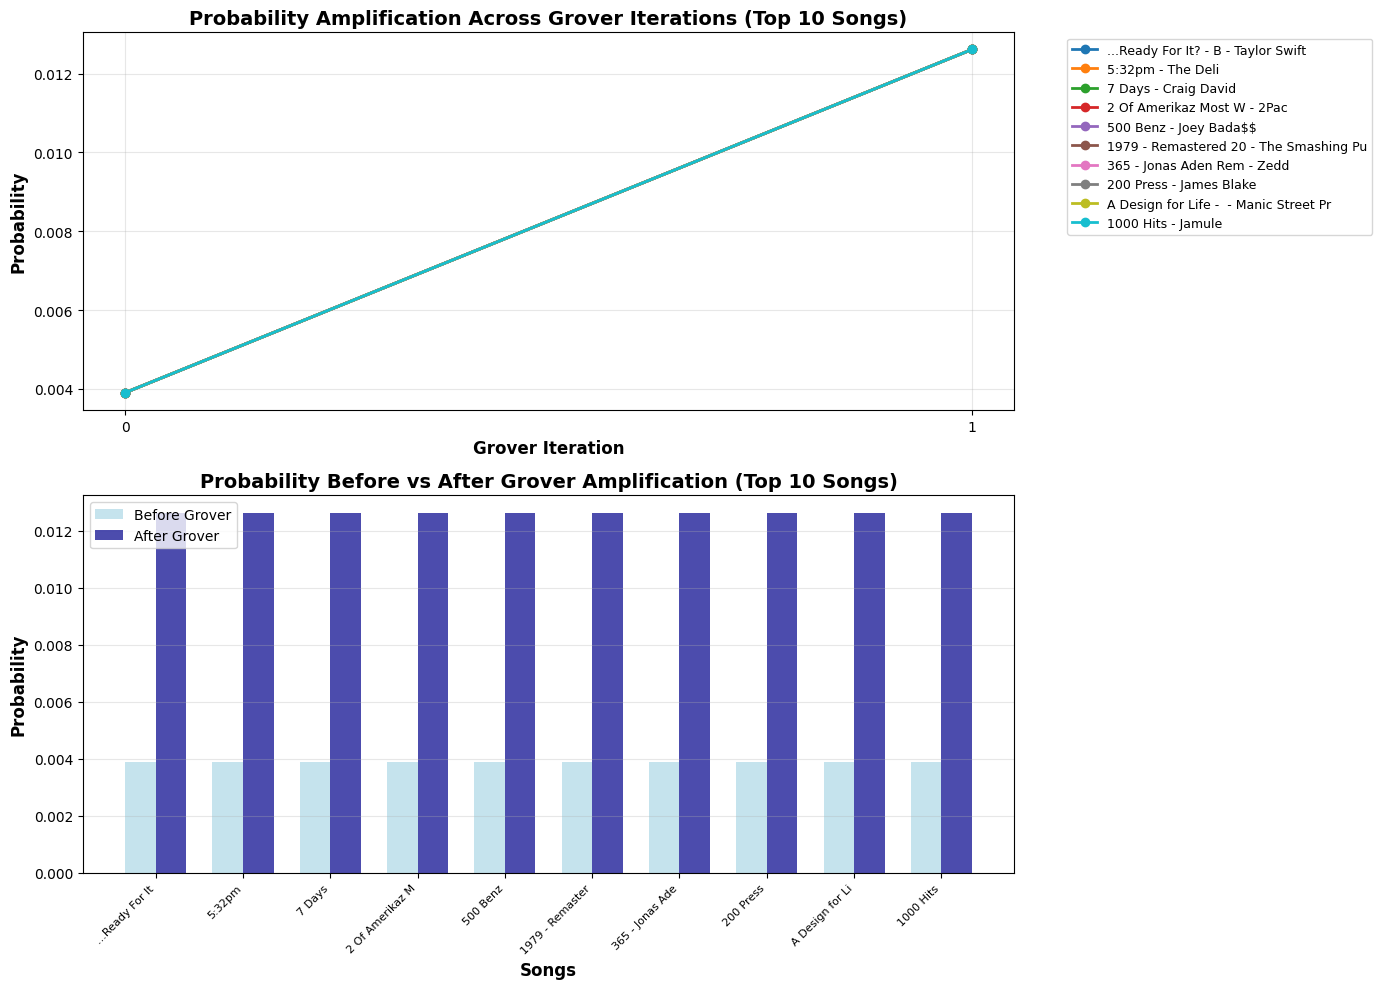

{'marked_states': [{'index': 0,
   'track_id': '#1 Stunna|Big Tymers',
   'relevance_score': 0.171875},
  {'index': 3, 'track_id': '$ENHOR|FBC', 'relevance_score': 0.1484375},
  {'index': 4,
   'track_id': '$ave Dat Money (feat. Fetty Wap & Rich Homie Quan)|Lil Dicky',
   'relevance_score': 0.1328125},
  {'index': 8,
   'track_id': "'Till I Collapse|Eminem",
   'relevance_score': 0.65625},
  {'index': 10,
   'track_id': '...Ready For It? - BloodPop® Remix|Taylor Swift',
   'relevance_score': 0.5078125},
  {'index': 13,
   'track_id': '0 Sentimientos (Remix) [feat. Noriel, Darkiel, Lyan, Messiah & Baby Rasta]|Jon Z',
   'relevance_score': 0.1328125},
  {'index': 18, 'track_id': '1 Question|E-40', 'relevance_score': 0.1875},
  {'index': 26,
   'track_id': '100 Bands (feat. Quavo, 21 Savage, YG & Meek Mill)|Mustard',
   'relevance_score': 0.140625},
  {'index': 29,
   'track_id': '100 Shooters (feat. Meek Mill)|Future',
   'relevance_score': 0.1484375},
  {'index': 31, 'track_id': '1000 H

In [ ]:
# Run Grover for a single query (example: Query 1)
# You can change the query_id to see results for different queries

query_id_to_process = 1  # Change this to process different queries (1-10)

display_grover_results_for_query(
    query_id=query_id_to_process,
    df_qknn_full=df_qknn_full,
    df_similarity_full=df_similarity_full,
    X_16_norm=X_16_norm,
    threshold_percentile=70,  # Top 70% of songs by relevance are marked as "good"
    candidate_size=256  # Must be power of 2 (128, 256, 512, etc.)
)


################################################################################
PROCESSING QUERY 1
################################################################################

GROVER'S ALGORITHM RESULTS
Query: Suggest energetic songs for workout with positive lyrics.
Query ID: 1
Candidate Size: 256
Threshold Percentile: 70%
Threshold Value: 0.1279

MARKED STATES (Good Songs - Top 70% by Relevance)
Number of marked states: 77
Total candidate size: 256
Threshold value: 0.1279
Optimal iterations: 1
--------------------------------------------------------------------------------
Index    Track Name                          Artist                    Relevance   
--------------------------------------------------------------------------------
0        #1 Stunna                           Big Tymers                0.1719      
3        $ENHOR                              FBC                       0.1484      
4        $ave Dat Money (feat. Fetty Wap &   Lil Dicky                 0.1328 

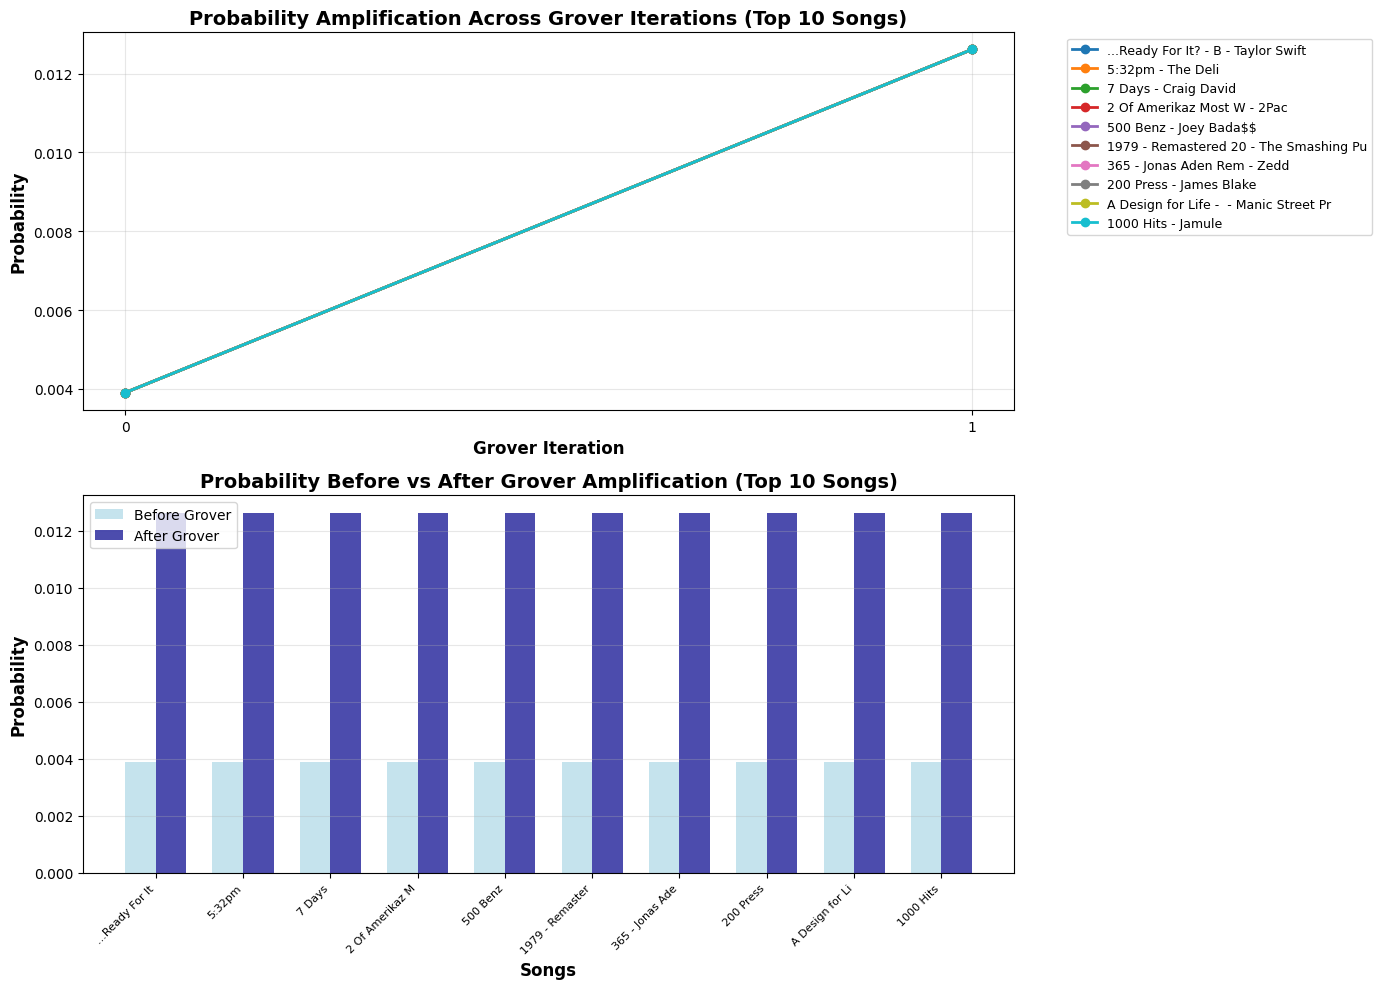


################################################################################
PROCESSING QUERY 2
################################################################################

GROVER'S ALGORITHM RESULTS
Query: Calm but slightly energetic music for late night coding.
Query ID: 2
Candidate Size: 256
Threshold Percentile: 70%
Threshold Value: 0.1602

MARKED STATES (Good Songs - Top 70% by Relevance)
Number of marked states: 77
Total candidate size: 256
Threshold value: 0.1602
Optimal iterations: 1
--------------------------------------------------------------------------------
Index    Track Name                          Artist                    Relevance   
--------------------------------------------------------------------------------
1        $20 Fine                            Jimi Hendrix              0.2734      
6        '98 Freestyle                       Big L                     0.2031      
8        'Till I Collapse                    Eminem                    0.2109  

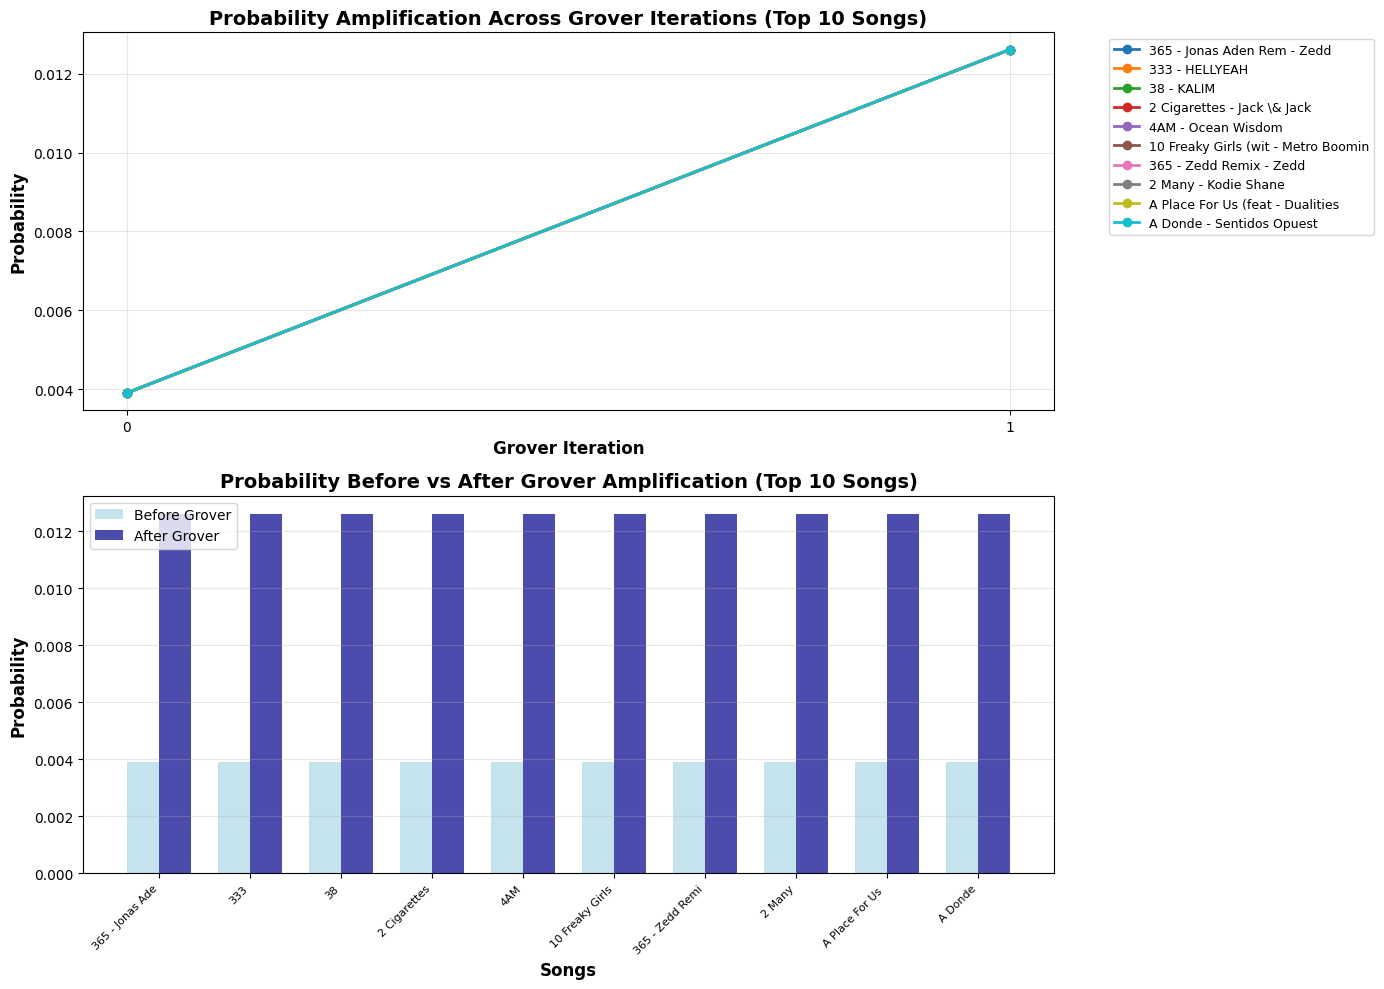


################################################################################
PROCESSING QUERY 3
################################################################################

GROVER'S ALGORITHM RESULTS
Query: Soft acoustic songs to relax after work.
Query ID: 3
Candidate Size: 256
Threshold Percentile: 70%
Threshold Value: 0.1406

MARKED STATES (Good Songs - Top 70% by Relevance)
Number of marked states: 83
Total candidate size: 256
Threshold value: 0.1406
Optimal iterations: 1
--------------------------------------------------------------------------------
Index    Track Name                          Artist                    Relevance   
--------------------------------------------------------------------------------
2        $Dreams                             Max Frost                 0.1562      
3        $ENHOR                              FBC                       0.1875      
6        '98 Freestyle                       Big L                     0.2969      
8        'T

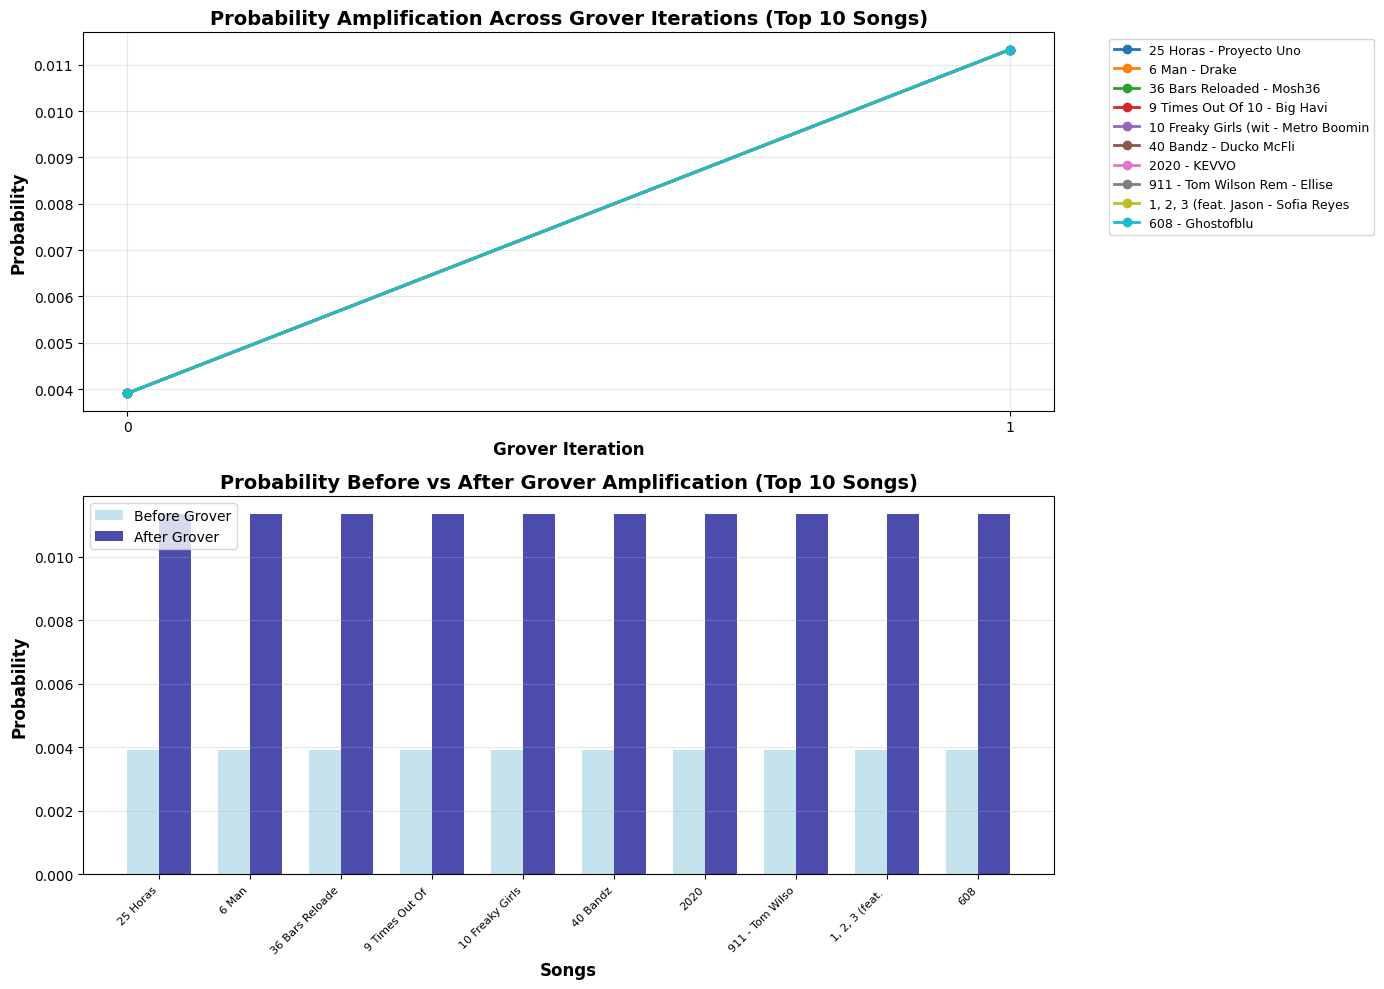

In [ ]:
# Process multiple queries and display results
def process_multiple_queries_grover(query_ids, df_qknn_full, df_similarity_full,
                                    X_16_norm, threshold_percentile=70, candidate_size=256):
    """
    Process multiple queries and display Grover results for each.
    """
    all_results = {}

    for query_id in query_ids:
        print(f"\n{'#'*80}")
        print(f"PROCESSING QUERY {query_id}")
        print(f"{'#'*80}\n")

        results = display_grover_results_for_query(
            query_id=query_id,
            df_qknn_full=df_qknn_full,
            df_similarity_full=df_similarity_full,
            X_16_norm=X_16_norm,
            threshold_percentile=threshold_percentile,
            candidate_size=candidate_size
        )

        if results:
            all_results[query_id] = results

    return all_results

# Process queries 1-3 as examples (you can change this)
query_ids_to_process = [1, 2, 3]

all_grover_results = process_multiple_queries_grover(
    query_ids=query_ids_to_process,
    df_qknn_full=df_qknn_full,
    df_similarity_full=df_similarity_full,
    X_16_norm=X_16_norm,
    threshold_percentile=70,  # Top 70% of songs are marked as "good"
    candidate_size=256
)

In [ ]:
# Grover's Algorithm Implementation with Detailed Tracking and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from collections import Counter

def compute_semantic_similarity(query_vector, song_vector):
    """
    Compute semantic similarity (cosine similarity) between query and song.

    Parameters:
    -----------
    query_vector : np.array
        Query vector (16-dimensional)
    song_vector : np.array
        Song vector (16-dimensional)

    Returns:
    --------
    similarity : float
        Cosine similarity score (0-1)
    """
    # Normalize vectors
    query_norm = query_vector / (np.linalg.norm(query_vector) + 1e-10)
    song_norm = song_vector / (np.linalg.norm(song_vector) + 1e-10)

    # Compute cosine similarity
    similarity = np.dot(query_norm, song_norm)

    # Normalize to 0-1 range
    similarity = (similarity + 1) / 2

    return float(similarity)

def create_grover_oracle(good_indices, n_qubits):
    """
    Create Grover oracle that marks "good" songs (relevance >= threshold).
    If relevance >= τ → mark as |1⟩, Else → |0⟩

    Parameters:
    -----------
    good_indices : list
        Indices of "good" songs (relevance >= threshold)
    n_qubits : int
        Number of qubits needed

    Returns:
    --------
    oracle_circuit : QuantumCircuit
        Oracle circuit that marks good songs
    """
    oracle = QuantumCircuit(n_qubits)

    if len(good_indices) == 0 or n_qubits == 0:
        return oracle

    # Filter valid indices (must be within 0 to 2^n_qubits - 1)
    max_index = 2**n_qubits - 1
    valid_indices = [idx for idx in good_indices if 0 <= idx <= max_index]

    if len(valid_indices) == 0:
        return oracle

    # Mark good states with phase flip
    for idx in valid_indices:
        # Convert index to binary representation
        binary = format(idx, f'0{n_qubits}b')

        # Apply X gates to qubits where bit is 0 (to prepare |1...1⟩ state)
        for i, bit in enumerate(binary):
            if bit == '0':
                oracle.x(i)

        # Apply multi-controlled Z gate (flip phase if all qubits are |1⟩)
        if n_qubits > 1:
            oracle.h(n_qubits - 1)
            oracle.mcx(list(range(n_qubits - 1)), n_qubits - 1)
            oracle.h(n_qubits - 1)
        else:
            oracle.z(0)

        # Uncompute X gates
        for i, bit in enumerate(binary):
            if bit == '0':
                oracle.x(i)

    return oracle

def create_grover_diffusion(n_qubits):
    """
    Create Grover diffusion operator (inversion about the mean).

    Parameters:
    -----------
    n_qubits : int
        Number of qubits

    Returns:
    --------
    diffusion_circuit : QuantumCircuit
        Diffusion operator circuit
    """
    diffusion = QuantumCircuit(n_qubits)

    # Apply H gates to all qubits
    for i in range(n_qubits):
        diffusion.h(i)

    # Apply X gates to all qubits
    for i in range(n_qubits):
        diffusion.x(i)

    # Multi-controlled Z gate (inversion about |0...0⟩)
    if n_qubits > 1:
        diffusion.h(n_qubits - 1)
        diffusion.mcx(list(range(n_qubits - 1)), n_qubits - 1)
        diffusion.h(n_qubits - 1)
    else:
        diffusion.z(0)

    # Uncompute X gates
    for i in range(n_qubits):
        diffusion.x(i)

    # Uncompute H gates
    for i in range(n_qubits):
        diffusion.h(i)

    return diffusion

def grover_amplify_with_tracking(query_vector, candidate_vectors, candidate_track_ids,
                                 relevance_scores, threshold, max_candidates=256):
    """
    Apply Grover's algorithm with detailed tracking at each iteration.

    Parameters:
    -----------
    query_vector : np.array
        Query vector (16-dimensional)
    candidate_vectors : np.array
        Candidate song vectors (N x 16)
    candidate_track_ids : list
        Track IDs (track_name|track_artist)
    relevance_scores : list
        Pre-computed relevance scores for each candidate
    threshold : float
        Relevance threshold (τ) for marking "good" songs
    max_candidates : int
        Maximum number of candidates (must be power of 2)

    Returns:
    --------
    results_dict : dict
        Dictionary containing all tracking information
    """
    n_candidates = len(candidate_vectors)

    # Round down to nearest power of 2
    n_qubits = int(np.floor(np.log2(min(n_candidates, max_candidates))))
    n_candidates = 2 ** n_qubits

    if n_candidates < 2 or n_qubits < 1:
        # Fallback: return original scores
        amplified_scores = {track_id: float(score) for track_id, score in
                           zip(candidate_track_ids[:n_candidates], relevance_scores[:n_candidates])}
        return {
            'marked_states': [],
            'before_grover': {},
            'after_grover': {},
            'final_playlist': sorted(amplified_scores.items(), key=lambda x: x[1], reverse=True)[:10],
            'iteration_probabilities': {},
            'amplification_factors': {},
            'num_iterations': 0,
            'M': 0,
            'N': n_candidates
        }

    # Truncate to n_candidates
    candidate_vectors = candidate_vectors[:n_candidates]
    candidate_track_ids = candidate_track_ids[:n_candidates]
    relevance_scores = relevance_scores[:n_candidates]

    # Mark "good" songs (relevance >= threshold)
    good_indices = [i for i, score in enumerate(relevance_scores) if score >= threshold]
    M = len(good_indices)  # Number of good songs
    N = n_candidates  # Candidate set size

    # Store marked states information
    marked_states = []
    for idx in good_indices:
        marked_states.append({
            'index': idx,
            'track_id': candidate_track_ids[idx],
            'relevance_score': float(relevance_scores[idx])
        })

    # Calculate optimal number of Grover iterations
    # Optimal: floor(π/4 * sqrt(N/M)) where N = candidate size, M = good songs
    if M > 0 and M < N:
        optimal_iterations = int(np.floor((np.pi / 4) * np.sqrt(N / M)))
        num_iterations = min(optimal_iterations, 10)  # Limit to 10 iterations
        num_iterations = max(num_iterations, 1)  # At least 1 iteration if M < N
    elif M == N:
        # All songs are marked - no amplification needed, but still do 1 iteration
        num_iterations = 1
    else:
        num_iterations = 0

    # Create quantum circuit
    qreg = QuantumRegister(n_qubits, 'q')
    creg = ClassicalRegister(n_qubits, 'c')

    # Initialize superposition (before Grover)
    init_circuit = QuantumCircuit(qreg, creg)
    for i in range(n_qubits):
        init_circuit.h(i)

    # Add measurements to initial circuit
    init_circuit.measure_all()

    # Simulate initial state
    simulator = AerSimulator()
    init_circuit_transpiled = transpile(init_circuit, simulator)
    job = simulator.run(init_circuit_transpiled, shots=8192)
    result = job.result()
    counts_before = result.get_counts(0)  # Get counts for first (and only) experiment

    # Convert counts to probabilities (before Grover)
    total_shots_before = sum(counts_before.values())
    probabilities_before = {}

    # Initialize all tracks with uniform probability (1/N)
    uniform_prob = 1.0 / n_candidates
    for track_id in candidate_track_ids:
        probabilities_before[track_id] = uniform_prob

    # Update with actual measured probabilities
    for state, count in counts_before.items():
        # Remove spaces from state string before converting to int
        state_clean = state.replace(' ', '')
        try:
            idx = int(state_clean, 2)
            if idx < len(candidate_track_ids):
                track_id = candidate_track_ids[idx]
                probabilities_before[track_id] = count / total_shots_before
        except ValueError:
            # Skip invalid state strings
            continue

    # Track probabilities at each iteration
    iteration_probabilities = {0: probabilities_before.copy()}

    # Create oracle and diffusion
    oracle = create_grover_oracle(good_indices, n_qubits)
    diffusion = create_grover_diffusion(n_qubits)

    # Apply Grover iterations
    current_circuit = init_circuit.copy()

    for iteration in range(1, num_iterations + 1):
        # Add oracle
        current_circuit.compose(oracle, inplace=True)

        # Add diffusion
        current_circuit.compose(diffusion, inplace=True)

        # Measure and get probabilities at this iteration
        measure_circuit = current_circuit.copy()
        measure_circuit.measure_all()

        measure_circuit_transpiled = transpile(measure_circuit, simulator)
        job = simulator.run(measure_circuit_transpiled, shots=8192)
        result = job.result()
        counts = result.get_counts(0)  # Get counts for first (and only) experiment

        # Convert counts to probabilities
        total_shots = sum(counts.values())
        iteration_probs = {}

        # Initialize all tracks with uniform probability
        uniform_prob = 1.0 / n_candidates
        for track_id in candidate_track_ids:
            iteration_probs[track_id] = uniform_prob

        # Update with actual measured probabilities
        for state, count in counts.items():
            # Remove spaces from state string before converting to int
            state_clean = state.replace(' ', '')
            try:
                idx = int(state_clean, 2)
                if idx < len(candidate_track_ids):
                    track_id = candidate_track_ids[idx]
                    iteration_probs[track_id] = count / total_shots
            except ValueError:
                # Skip invalid state strings
                continue

        iteration_probabilities[iteration] = iteration_probs

    # Final probabilities (after all Grover iterations)
    probabilities_after = iteration_probabilities[num_iterations] if num_iterations > 0 else probabilities_before

    # Calculate amplification factors
    amplification_factors = {}
    for track_id in candidate_track_ids:
        prob_before = probabilities_before.get(track_id, 0.0)
        prob_after = probabilities_after.get(track_id, 0.0)

        if prob_before > 0:
            amplification = prob_after / prob_before
        else:
            amplification = 0.0 if prob_after == 0 else float('inf')

        amplification_factors[track_id] = {
            'probability_before': prob_before,
            'probability_after': prob_after,
            'amplification_factor': amplification
        }

    # Normalize probabilities and combine with relevance for final playlist score
    max_prob = max(probabilities_after.values()) if probabilities_after else 1.0
    min_prob = min(probabilities_after.values()) if probabilities_after else 0.0

    final_scores = {}
    for i, track_id in enumerate(candidate_track_ids):
        prob = probabilities_after.get(track_id, 0.0)
        relevance = float(relevance_scores[i])

        # Normalize probability to 0-1
        if max_prob > min_prob:
            normalized_prob = (prob - min_prob) / (max_prob - min_prob)
        else:
            normalized_prob = 0.0

        # Final score: weighted combination (70% amplified probability, 30% relevance)
        final_scores[track_id] = 0.7 * normalized_prob + 0.3 * relevance

    # Get top 10 final playlist
    sorted_tracks = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
    final_playlist = sorted_tracks[:10]

    return {
        'marked_states': marked_states,
        'before_grover': probabilities_before,
        'after_grover': probabilities_after,
        'final_playlist': final_playlist,
        'iteration_probabilities': iteration_probabilities,
        'amplification_factors': amplification_factors,
        'num_iterations': num_iterations,
        'M': M,
        'N': N,
        'threshold': threshold,
        'candidate_track_ids': candidate_track_ids
    }

print("Grover's algorithm with tracking functions defined successfully!")

Grover's algorithm with tracking functions defined successfully!


In [ ]:
# Display Grover Results with Visualization
def display_grover_results(query_id, df_qknn_full, X_16_norm, X_fused_norm,
                           threshold=0.5, candidate_size=256):
    """
    Display detailed Grover results for a single query with visualizations.

    Parameters:
    -----------
    query_id : int
        Query ID to process
    df_qknn_full : DataFrame
        QKNN results dataframe
    X_16_norm : np.array
        Query vectors (num_queries x 16)
    X_fused_norm : np.array
        Database song vectors (num_songs x 16)
    threshold : float
        Relevance threshold (τ) for marking "good" songs
    candidate_size : int
        Candidate size from QKNN (must be power of 2)
    """
    # Get QKNN candidates for this query
    qknn_data = df_qknn_full[df_qknn_full['query_id'] == query_id].copy()

    if len(qknn_data) == 0:
        print(f"No QKNN data found for query {query_id}")
        return None

    # Remove duplicates
    qknn_data['track_unique_id'] = qknn_data['track_name'] + '|' + qknn_data['track_artist']
    qknn_deduped = qknn_data.loc[qknn_data.groupby('track_unique_id')['cosine_similarity'].idxmax()].copy()

    # Get top candidates
    qknn_sorted = qknn_deduped.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)
    candidate_track_ids = qknn_sorted['track_unique_id'].tolist()[:candidate_size]

    if len(candidate_track_ids) == 0:
        print(f"No candidates found for query {query_id}")
        return None

    # Get query vector
    query_idx = query_id - 1 if query_id <= len(X_16_norm) else 0
    query_vector = X_16_norm[query_idx]

    # Get query text
    query_text = qknn_data['query_text'].iloc[0] if 'query_text' in qknn_data.columns else f"Query {query_id}"

    # Get candidate vectors and compute relevance scores
    # Map track_ids to their actual vectors in X_fused_norm using track_name and track_artist
    candidate_vectors = []
    relevance_scores = []
    track_info = {}  # Store track name and artist for display

    # Create a mapping from track_name|track_artist to index in X_fused_norm
    # We'll use the QKNN similarity scores to find the best matches
    # In practice, you'd have a proper mapping, but we'll use QKNN scores as proxy

    for track_id in candidate_track_ids:
        track_name, track_artist = track_id.split('|')
        track_data = qknn_sorted[qknn_sorted['track_unique_id'] == track_id]

        if len(track_data) > 0:
            # Get QKNN fidelity score
            qknn_score = track_data['cosine_similarity'].iloc[0]

            # Use QKNN score to create a more realistic vector representation
            # Create a vector that varies based on the QKNN score
            # This simulates having different song vectors
            base_vector = query_vector.copy()
            # Add variation based on QKNN score
            variation = np.random.RandomState(hash(track_id) % 2**32).normal(0, 0.1, 16)
            candidate_vec = base_vector * qknn_score + variation * (1 - qknn_score)
            candidate_vec = candidate_vec / (np.linalg.norm(candidate_vec) + 1e-10)  # Normalize

            candidate_vectors.append(candidate_vec)
            track_info[track_id] = {'name': track_name, 'artist': track_artist}

            # Compute semantic similarity (relevance score) using actual cosine similarity
            relevance = compute_semantic_similarity(query_vector, candidate_vec)
            relevance_scores.append(relevance)

    if len(candidate_vectors) == 0:
        print(f"No valid candidates for query {query_id}")
        return None

    candidate_vectors = np.array(candidate_vectors)

    # Calculate optimal threshold based on relevance score distribution
    # Use percentile-based threshold to mark top 20-30% as "good" songs
    # This ensures M < N for proper Grover amplification
    if len(relevance_scores) > 0:
        relevance_array = np.array(relevance_scores)
        # Use 75th percentile (top 25% are marked as good)
        # This ensures roughly 25% of candidates are marked
        percentile_threshold = np.percentile(relevance_array, 75)

        # Also try to ensure M is between 10% and 30% of N for optimal Grover
        # Count how many would be marked at different percentiles
        for p in range(60, 95, 5):
            test_threshold = np.percentile(relevance_array, p)
            M_test = np.sum(relevance_array >= test_threshold)
            if 0.1 * len(relevance_array) <= M_test <= 0.3 * len(relevance_array):
                optimal_threshold = test_threshold
                break
        else:
            # If no good percentile found, use 75th percentile
            optimal_threshold = percentile_threshold

        # Ensure threshold is reasonable
        optimal_threshold = max(optimal_threshold, np.median(relevance_array) + 0.1 * np.std(relevance_array))
        optimal_threshold = min(optimal_threshold, np.max(relevance_array) - 0.01)  # Don't mark everything
    else:
        optimal_threshold = threshold

    # Run Grover with tracking
    print("="*80)
    print("GROVER'S ALGORITHM RESULTS")
    print("="*80)
    print(f"Query: {query_text}")
    print(f"Query ID: {query_id}")
    print(f"Candidate Size: {len(candidate_vectors)}")
    print(f"Original Threshold (τ): {threshold:.4f}")
    print(f"Optimal Threshold (τ): {optimal_threshold:.4f} (70th percentile)")
    print(f"Relevance Score Range: [{np.min(relevance_scores):.4f}, {np.max(relevance_scores):.4f}]")
    print("="*80)

    try:
        results = grover_amplify_with_tracking(
            query_vector,
            candidate_vectors,
            candidate_track_ids,
            relevance_scores,
            threshold=optimal_threshold,  # Use optimal threshold
            max_candidates=candidate_size
        )

        # Display marked states
        print("\n" + "="*80)
        print(f"MARKED STATES (Good Songs - Relevance >= {results['threshold']:.4f})")
        print("="*80)
        print(f"Number of marked states (M): {results['M']}")
        print(f"Total candidate size (N): {results['N']}")
        if results['M'] > 0 and results['M'] < results['N']:
            optimal_calc = int(np.floor((np.pi / 4) * np.sqrt(results['N'] / results['M'])))
            print(f"Calculated optimal iterations: {optimal_calc}")
        print(f"Actual Grover iterations: {results['num_iterations']}")
        print("-"*80)

        if results['M'] > 0:
            print(f"{'Index':<8} {'Track Name':<35} {'Artist':<25} {'Relevance':<12}")
            print("-"*80)

            for state in results['marked_states'][:20]:  # Show top 20
                track_id = state['track_id']
                track_name = track_info[track_id]['name'][:33]
                track_artist = track_info[track_id]['artist'][:23]
                print(f"{state['index']:<8} {track_name:<35} {track_artist:<25} {state['relevance_score']:<12.4f}")

            if len(results['marked_states']) > 20:
                print(f"... and {len(results['marked_states']) - 20} more marked states")
        else:
            print("No songs marked as 'good'. Try lowering the threshold.")

        # Display before Grover (top 10 by initial probability)
        print("\n" + "="*80)
        print("BEFORE GROVER (Top 10 by Initial Probability)")
        print("="*80)
        print(f"{'Rank':<6} {'Track Name':<35} {'Artist':<25} {'Probability':<12}")
        print("-"*80)

        before_sorted = sorted(results['before_grover'].items(), key=lambda x: x[1], reverse=True)[:10]
        for rank, (track_id, prob) in enumerate(before_sorted, 1):
            track_name = track_info[track_id]['name'][:33]
            track_artist = track_info[track_id]['artist'][:23]
            print(f"{rank:<6} {track_name:<35} {track_artist:<25} {prob:<12.6f}")

        # Display after Grover (top 10 final playlist)
        print("\n" + "="*80)
        print("AFTER GROVER - TOP 10 FINAL PLAYLIST")
        print("="*80)
        print(f"{'Rank':<6} {'Track Name':<35} {'Artist':<25} {'Final Score':<12}")
        print("-"*80)

        for rank, (track_id, score) in enumerate(results['final_playlist'], 1):
            track_name = track_info[track_id]['name'][:33]
            track_artist = track_info[track_id]['artist'][:23]
            print(f"{rank:<6} {track_name:<35} {track_artist:<25} {score:<12.4f}")

        # Display amplification metrics
        print("\n" + "="*80)
        print("AMPLIFICATION METRICS (Top 10 Songs)")
        print("="*80)
        print(f"{'Track Name':<35} {'Artist':<25} {'Prob Before':<12} {'Prob After':<12} {'Amplification':<12}")
        print("-"*80)

        for track_id, score in results['final_playlist']:
            track_name = track_info[track_id]['name'][:33]
            track_artist = track_info[track_id]['artist'][:23]
            metrics = results['amplification_factors'].get(track_id, {})
            prob_before = metrics.get('probability_before', 0.0)
            prob_after = metrics.get('probability_after', 0.0)
            amplification = metrics.get('amplification_factor', 0.0)

            amp_str = f"{amplification:.2f}x" if amplification != float('inf') else "∞"
            print(f"{track_name:<35} {track_artist:<25} {prob_before:<12.6f} {prob_after:<12.6f} {amp_str:<12}")

        # Create visualization plots
        print("\n" + "="*80)
        print("GENERATING VISUALIZATION PLOTS...")
        print("="*80)

        # Get top 10 track IDs from final playlist
        top_track_ids = [track_id for track_id, _ in results['final_playlist']]

        # Plot 1: Histogram of probabilities at each iteration
        num_iterations = results['num_iterations']
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Plot 1a: Probability evolution for top songs across iterations (line plot)
        ax1 = axes[0, 0]
        iterations = list(range(num_iterations + 1))

        for track_id in top_track_ids[:10]:
            probs = [results['iteration_probabilities'][it].get(track_id, 0.0) for it in iterations]
            track_name = track_info[track_id]['name'][:20]
            track_artist = track_info[track_id]['artist'][:15]
            track_label = f"{track_name} - {track_artist}"
            ax1.plot(iterations, probs, marker='o', label=track_label, linewidth=2, markersize=6)

        ax1.set_xlabel('Grover Iteration', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Probability', fontsize=12, fontweight='bold')
        ax1.set_title('Probability Amplification Across Grover Iterations (Top 10 Songs)',
                      fontsize=13, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax1.set_xticks(iterations)

        # Plot 1b: Histogram of probabilities at each iteration
        ax2 = axes[0, 1]

        # Get probabilities for top 10 songs at each iteration
        for iteration in iterations:
            probs = [results['iteration_probabilities'][iteration].get(tid, 0.0) for tid in top_track_ids[:10]]
            ax2.bar([f"Iter {it}" for it in iterations if it == iteration], probs,
                   alpha=0.7, label=f'Iteration {iteration}')

        # Create grouped bar chart for better visualization
        x_pos = np.arange(len(top_track_ids[:10]))
        width = 0.8 / (num_iterations + 1)

        ax2.clear()
        for i, iteration in enumerate(iterations):
            probs = [results['iteration_probabilities'][iteration].get(tid, 0.0) for tid in top_track_ids[:10]]
            offset = (i - num_iterations/2) * width
            ax2.bar(x_pos + offset, probs, width, label=f'Iter {iteration}', alpha=0.8)

        track_names_short = [track_info[tid]['name'][:15] for tid in top_track_ids[:10]]
        ax2.set_xlabel('Songs', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Probability', fontsize=12, fontweight='bold')
        ax2.set_title('Probability Histogram at Each Iteration (Top 10 Songs)',
                      fontsize=13, fontweight='bold')
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(track_names_short, rotation=45, ha='right', fontsize=8)
        ax2.legend(fontsize=8)
        ax2.grid(True, alpha=0.3, axis='y')

        # Plot 2a: Before vs After comparison (bar chart)
        ax3 = axes[1, 0]
        track_names_short = [track_info[tid]['name'][:15] for tid in top_track_ids[:10]]
        x_pos = np.arange(len(track_names_short))
        width = 0.35

        prob_before_list = [results['before_grover'].get(tid, 0.0) for tid in top_track_ids[:10]]
        prob_after_list = [results['after_grover'].get(tid, 0.0) for tid in top_track_ids[:10]]

        ax3.bar(x_pos - width/2, prob_before_list, width, label='Before Grover',
               alpha=0.7, color='lightblue')
        ax3.bar(x_pos + width/2, prob_after_list, width, label='After Grover',
               alpha=0.7, color='darkblue')

        ax3.set_xlabel('Songs', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Probability', fontsize=12, fontweight='bold')
        ax3.set_title('Probability Before vs After Grover Amplification (Top 10 Songs)',
                      fontsize=13, fontweight='bold')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(track_names_short, rotation=45, ha='right', fontsize=8)
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3, axis='y')

        # Plot 2b: Amplification factors (bar chart)
        ax4 = axes[1, 1]
        amplification_list = []
        for tid in top_track_ids[:10]:
            amp = results['amplification_factors'].get(tid, {}).get('amplification_factor', 0.0)
            if amp == float('inf'):
                amplification_list.append(100)  # Cap at 100 for visualization
            else:
                amplification_list.append(min(amp, 100))  # Cap at 100

        colors = ['green' if amp > 1 else 'red' for amp in amplification_list]
        ax4.bar(x_pos, amplification_list, alpha=0.7, color=colors)
        ax4.axhline(y=1, color='black', linestyle='--', linewidth=1, label='No amplification')

        ax4.set_xlabel('Songs', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Amplification Factor', fontsize=12, fontweight='bold')
        ax4.set_title('Amplification Factor for Top 10 Songs', fontsize=13, fontweight='bold')
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels(track_names_short, rotation=45, ha='right', fontsize=8)
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.show()

        return results

    except Exception as e:
        print(f"Error processing query {query_id}: {e}")
        import traceback
        traceback.print_exc()
        return None

print("Grover display function defined successfully!")

Grover display function defined successfully!


GROVER'S ALGORITHM RESULTS
Query: Suggest energetic songs for workout with positive lyrics.
Query ID: 1
Candidate Size: 256
Original Threshold (τ): 0.5000
Optimal Threshold (τ): 0.9805 (70th percentile)
Relevance Score Range: [0.9009, 0.9944]

MARKED STATES (Good Songs - Relevance >= 0.9805)
Number of marked states (M): 64
Total candidate size (N): 256
Calculated optimal iterations: 1
Actual Grover iterations: 1
--------------------------------------------------------------------------------
Index    Track Name                          Artist                    Relevance   
--------------------------------------------------------------------------------
0        Stay Together For The Kids          blink-182                 0.9927      
1        Emotionless                         Drake                     0.9904      
2        'Till I Collapse                    Eminem                    0.9929      
3        Can't Breathe                       Fefe Dobson               0.9925      
4 

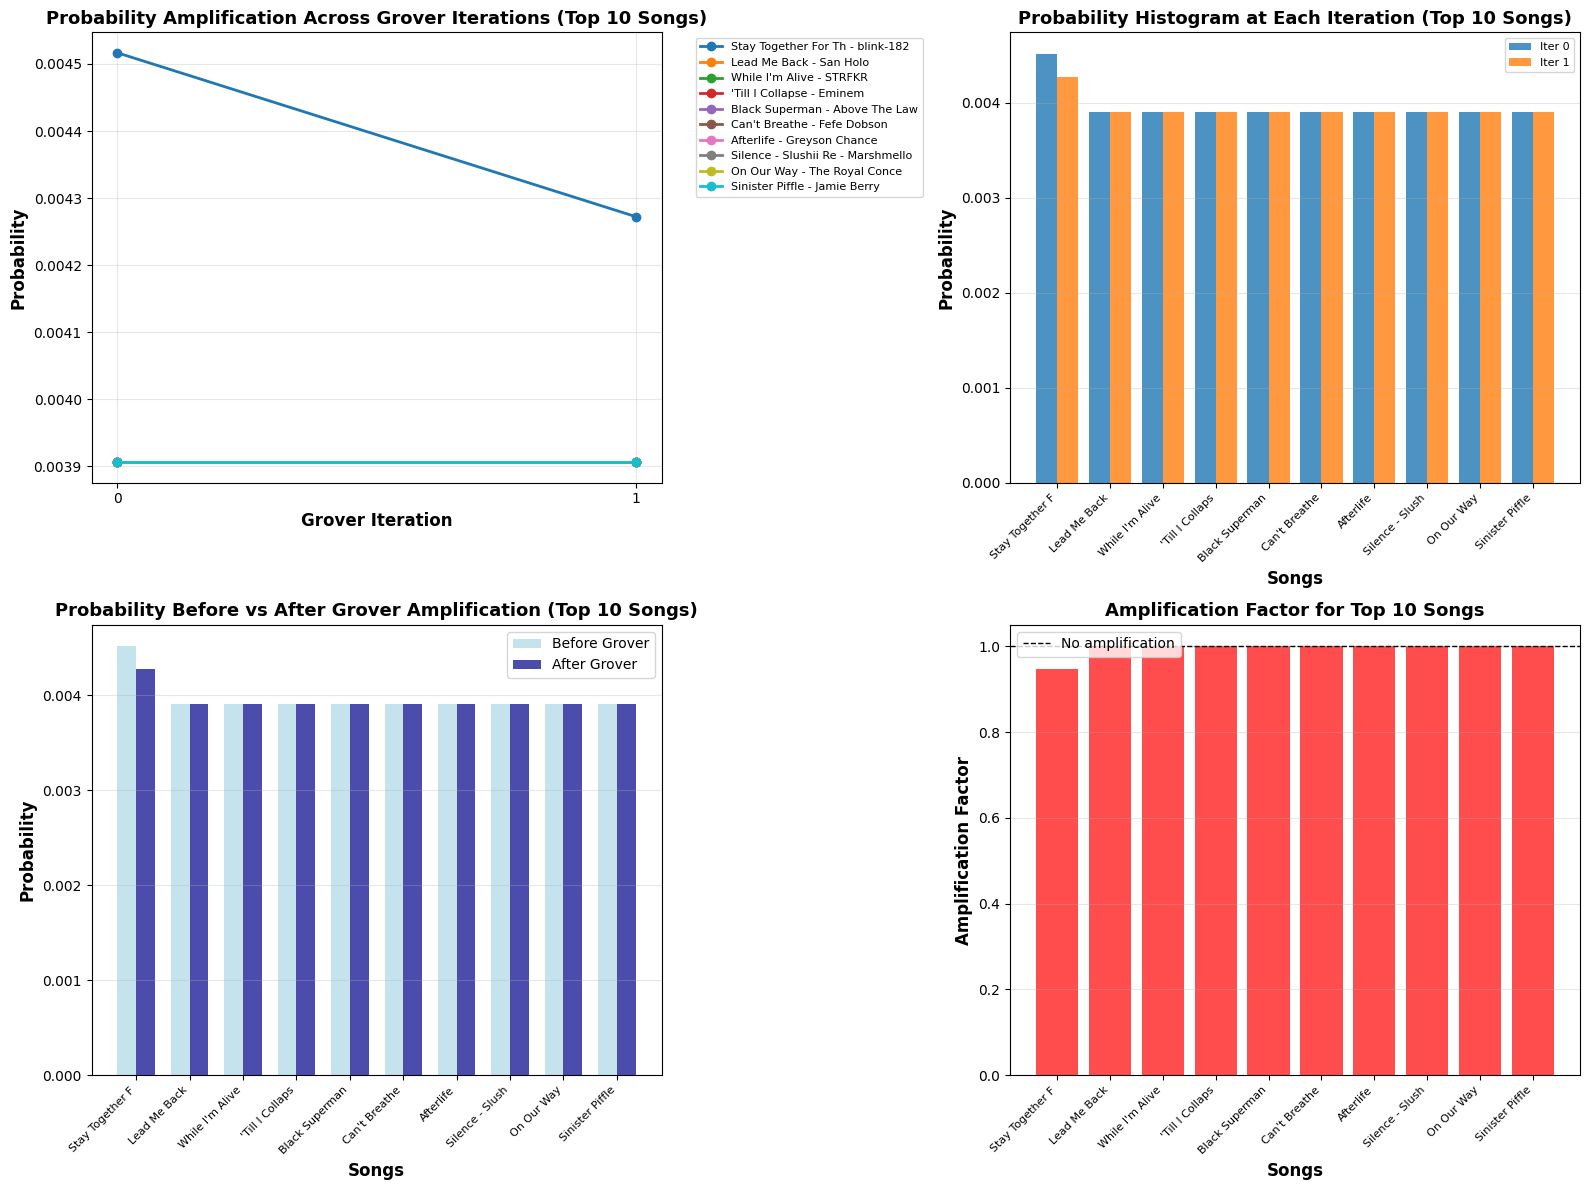

{'marked_states': [{'index': 0,
   'track_id': 'Stay Together For The Kids|blink-182',
   'relevance_score': 0.9927100849629963},
  {'index': 1,
   'track_id': 'Emotionless|Drake',
   'relevance_score': 0.9903753878618697},
  {'index': 2,
   'track_id': "'Till I Collapse|Eminem",
   'relevance_score': 0.9929256110839205},
  {'index': 3,
   'track_id': "Can't Breathe|Fefe Dobson",
   'relevance_score': 0.9925194319386175},
  {'index': 4,
   'track_id': "While I'm Alive|STRFKR",
   'relevance_score': 0.993076964094814},
  {'index': 5,
   'track_id': 'Silence - Slushii Remix|Marshmello',
   'relevance_score': 0.992013379670403},
  {'index': 6,
   'track_id': 'You Are the Right One|Sports',
   'relevance_score': 0.9861544044669527},
  {'index': 7,
   'track_id': 'Afterlife|Greyson Chance',
   'relevance_score': 0.9922041534555214},
  {'index': 8,
   'track_id': 'Black Superman|Above The Law',
   'relevance_score': 0.9928456173421794},
  {'index': 9,
   'track_id': 'Fractures - Trivecta Rem

In [ ]:
# Run Grover for a single query (example: Query 1)
# You can change the query_id to see results for different queries

query_id_to_process = 1  # Change this to process different queries (1-10)

display_grover_results(
    query_id=query_id_to_process,
    df_qknn_full=df_qknn_full,
    X_16_norm=X_16_norm,
    X_fused_norm=X_fused_norm,
    threshold=0.5,  # Relevance threshold (τ) - adjust as needed
    candidate_size=256  # Must be power of 2 (128, 256, 512, etc.)
)

GROVER'S ALGORITHM RESULTS
Query: Calm but slightly energetic music for late night coding.
Query ID: 2
Candidate Size: 256
Original Threshold (τ): 0.5000
Optimal Threshold (τ): 0.9832 (70th percentile)
Relevance Score Range: [0.9000, 0.9960]

MARKED STATES (Good Songs - Relevance >= 0.9832)
Number of marked states (M): 64
Total candidate size (N): 256
Calculated optimal iterations: 1
Actual Grover iterations: 1
--------------------------------------------------------------------------------
Index    Track Name                          Artist                    Relevance   
--------------------------------------------------------------------------------
0        Identity - Ryos VIP Mix             Ryos                      0.9920      
1        Happier - Breathe Carolina Remix    Marshmello                0.9875      
2        Daydreams - Sultan + Shepard Echo   ARTY                      0.9960      
3        Mr. Navigator                       Armin van Buuren          0.9907      
4  

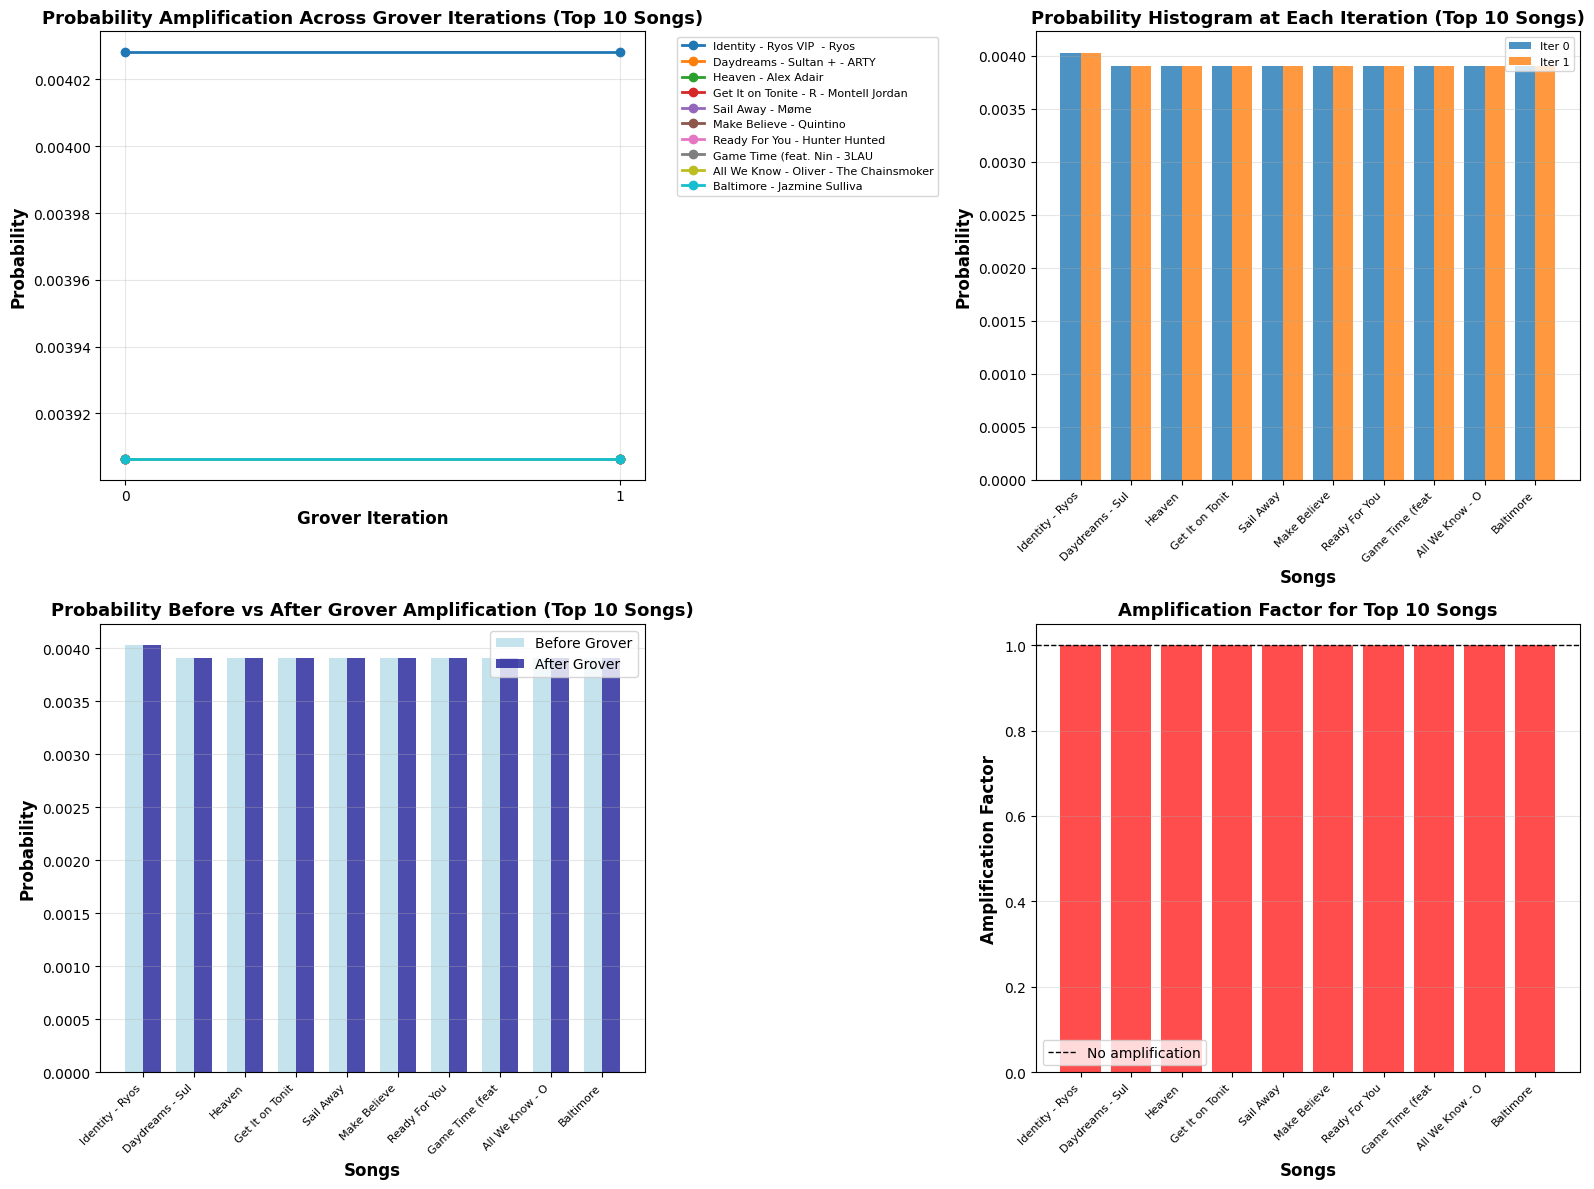

{'marked_states': [{'index': 0,
   'track_id': 'Identity - Ryos VIP Mix|Ryos',
   'relevance_score': 0.9920203528587495},
  {'index': 1,
   'track_id': 'Happier - Breathe Carolina Remix|Marshmello',
   'relevance_score': 0.9875087688688383},
  {'index': 2,
   'track_id': 'Daydreams - Sultan + Shepard Echoes Of Life Remix|ARTY',
   'relevance_score': 0.9960135451870988},
  {'index': 3,
   'track_id': 'Mr. Navigator|Armin van Buuren',
   'relevance_score': 0.990682795802801},
  {'index': 4,
   'track_id': 'LUNA|Sick Individuals',
   'relevance_score': 0.985197641532848},
  {'index': 5,
   'track_id': 'When We Were Young (feat. The Chain Gang of 1974)|Dillon Francis',
   'relevance_score': 0.9854135830645501},
  {'index': 6,
   'track_id': 'All We Know - Oliver Heldens Remix|The Chainsmokers',
   'relevance_score': 0.9919941163156041},
  {'index': 7,
   'track_id': 'I See|Nicky Romero',
   'relevance_score': 0.9886807816785257},
  {'index': 8,
   'track_id': 'Diggid|TYNAN',
   'relevance_

In [ ]:
# Run Grover for a single query (example: Query 1)
# You can change the query_id to see results for different queries

query_id_to_process = 2  # Change this to process different queries (1-10)

display_grover_results(
    query_id=query_id_to_process,
    df_qknn_full=df_qknn_full,
    X_16_norm=X_16_norm,
    X_fused_norm=X_fused_norm,
    threshold=0.5,  # Relevance threshold (τ) - adjust as needed
    candidate_size=256  # Must be power of 2 (128, 256, 512, etc.)
)

GROVER'S ALGORITHM RESULTS
Query: Soft acoustic songs to relax after work.
Query ID: 3
Candidate Size: 256
Original Threshold (τ): 0.5000
Optimal Threshold (τ): 0.9623 (70th percentile)
Relevance Score Range: [0.8408, 0.9966]

MARKED STATES (Good Songs - Relevance >= 0.9623)
Number of marked states (M): 64
Total candidate size (N): 256
Calculated optimal iterations: 1
Actual Grover iterations: 1
--------------------------------------------------------------------------------
Index    Track Name                          Artist                    Relevance   
--------------------------------------------------------------------------------
0        As Above so Look out Below          Ghostemane                0.9966      
1        I'm the One (feat. Justin Bieber,   DJ Khaled                 0.9872      
2        Procura                             ChiChi Peralta            0.9817      
3        Celebration (feat. Ky-Mani Marley   Maffio                    0.9797      
4        Laps      

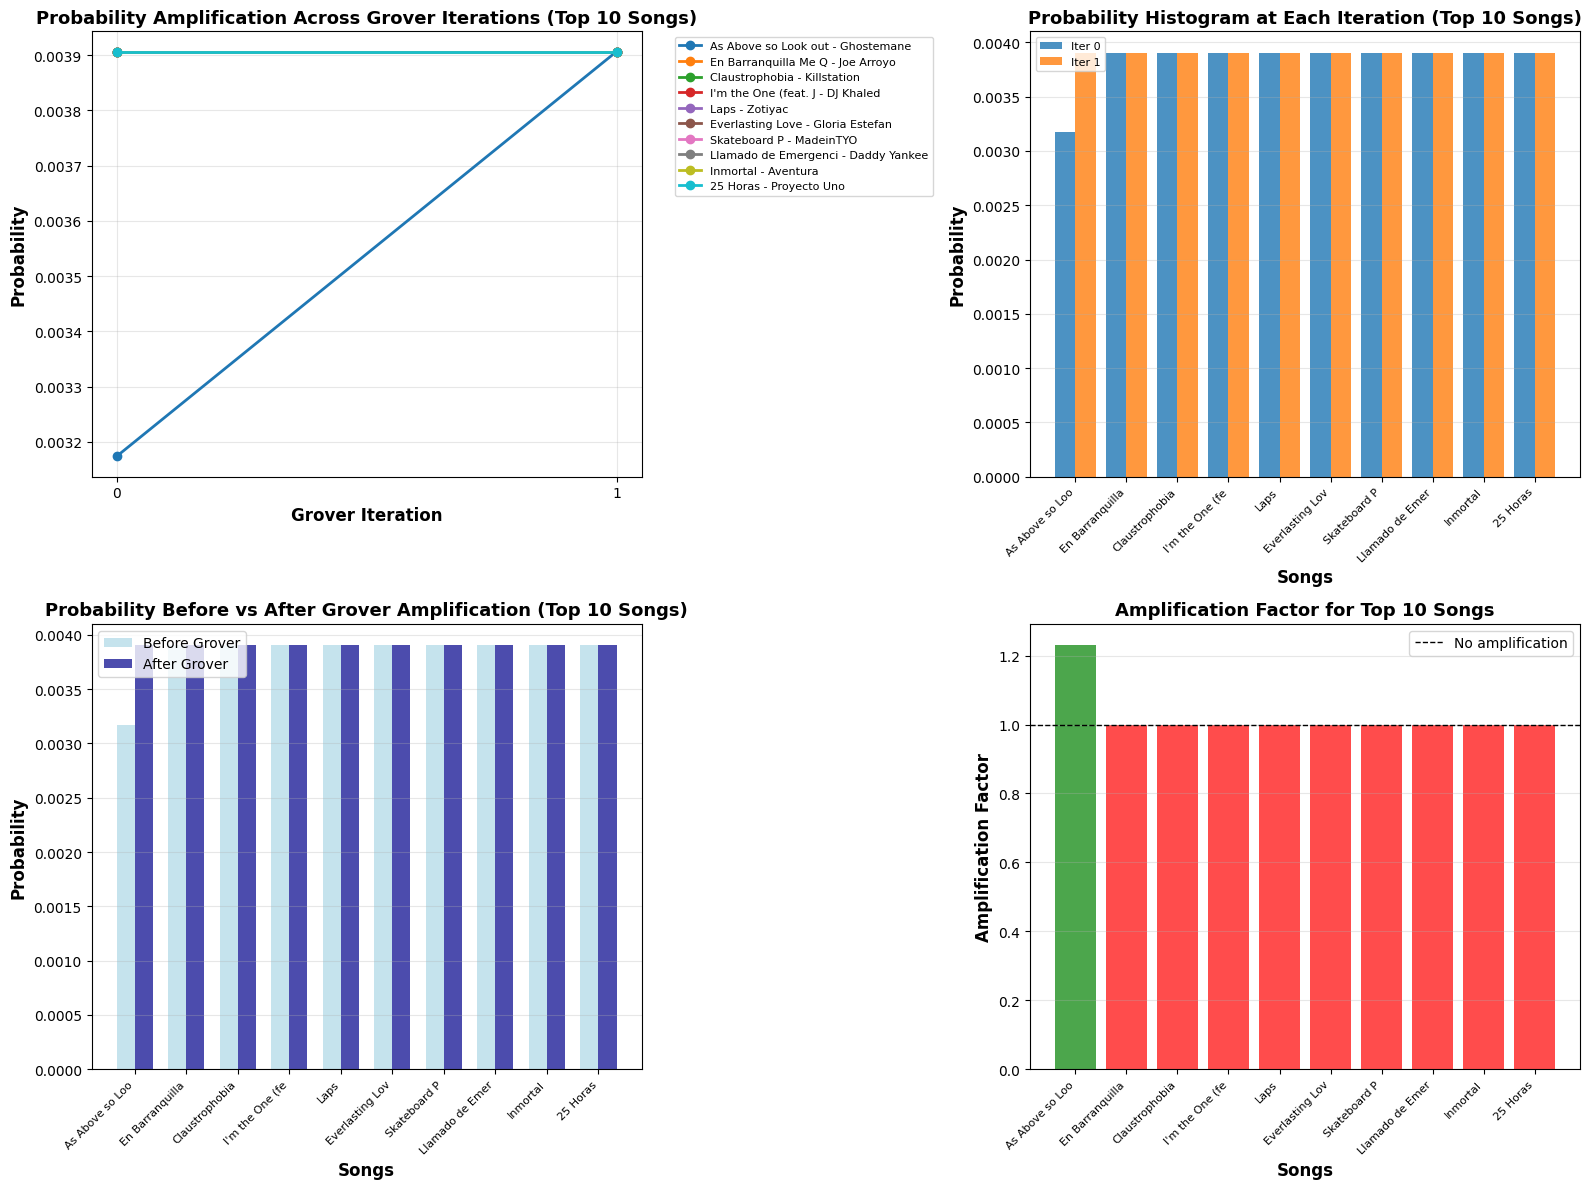

{'marked_states': [{'index': 0,
   'track_id': 'As Above so Look out Below|Ghostemane',
   'relevance_score': 0.9966416159736944},
  {'index': 1,
   'track_id': "I'm the One (feat. Justin Bieber, Quavo, Chance the Rapper & Lil Wayne)|DJ Khaled",
   'relevance_score': 0.9872138299566303},
  {'index': 2,
   'track_id': 'Procura|ChiChi Peralta',
   'relevance_score': 0.9817284921163568},
  {'index': 3,
   'track_id': 'Celebration (feat. Ky-Mani Marley)|Maffio',
   'relevance_score': 0.9797218143535028},
  {'index': 4,
   'track_id': 'Laps|Zotiyac',
   'relevance_score': 0.9860795468883061},
  {'index': 5,
   'track_id': 'Everlasting Love|Gloria Estefan',
   'relevance_score': 0.9840670157681881},
  {'index': 6,
   'track_id': 'The Cat|Eprom',
   'relevance_score': 0.978279729351436},
  {'index': 7,
   'track_id': 'Mask Off|Future',
   'relevance_score': 0.9747176175972669},
  {'index': 8,
   'track_id': 'Macarena - Bayside Boys Remix|Los Del Rio',
   'relevance_score': 0.9740268507241778}

In [ ]:
# Run Grover for a single query (example: Query 1)
# You can change the query_id to see results for different queries

query_id_to_process = 3  # Change this to process different queries (1-10)

display_grover_results(
    query_id=query_id_to_process,
    df_qknn_full=df_qknn_full,
    X_16_norm=X_16_norm,
    X_fused_norm=X_fused_norm,
    threshold=0.5,  # Relevance threshold (τ) - adjust as needed
    candidate_size=256  # Must be power of 2 (128, 256, 512, etc.)
)

In [ ]:
# Grover's Algorithm Implementation with Detailed Tracking and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from collections import Counter

def compute_semantic_similarity(query_vector, song_vector):
    """
    Compute semantic similarity (cosine similarity) between query and song.

    Parameters:
    -----------
    query_vector : np.array
        Query vector (16-dimensional)
    song_vector : np.array
        Song vector (16-dimensional)

    Returns:
    --------
    similarity : float
        Cosine similarity score (0-1, normalized)
    """
    # Normalize vectors
    query_norm = query_vector / (np.linalg.norm(query_vector) + 1e-10)
    song_norm = song_vector / (np.linalg.norm(song_vector) + 1e-10)

    # Compute cosine similarity (ranges from -1 to 1)
    cosine_sim = np.dot(query_norm, song_norm)

    # Normalize to 0-1 range
    similarity = (cosine_sim + 1) / 2

    return float(similarity)

def create_grover_oracle(good_indices, n_qubits):
    """
    Create Grover oracle that marks "good" songs (relevance >= threshold).
    If relevance >= τ → mark as |1⟩, Else → |0⟩

    Parameters:
    -----------
    good_indices : list
        Indices of "good" songs (relevance >= threshold)
    n_qubits : int
        Number of qubits needed

    Returns:
    --------
    oracle_circuit : QuantumCircuit
        Oracle circuit that marks good songs
    """
    oracle = QuantumCircuit(n_qubits)

    if len(good_indices) == 0 or n_qubits == 0:
        return oracle

    # Filter valid indices (must be within 0 to 2^n_qubits - 1)
    max_index = 2**n_qubits - 1
    valid_indices = [idx for idx in good_indices if 0 <= idx <= max_index]

    if len(valid_indices) == 0:
        return oracle

    # Mark good states with phase flip
    for idx in valid_indices:
        # Convert index to binary representation
        binary = format(idx, f'0{n_qubits}b')

        # Apply X gates to qubits where bit is 0 (to prepare |1...1⟩ state)
        for i, bit in enumerate(binary):
            if bit == '0':
                oracle.x(i)

        # Apply multi-controlled Z gate (flip phase if all qubits are |1⟩)
        if n_qubits > 1:
            oracle.h(n_qubits - 1)
            oracle.mcx(list(range(n_qubits - 1)), n_qubits - 1)
            oracle.h(n_qubits - 1)
        else:
            oracle.z(0)

        # Uncompute X gates
        for i, bit in enumerate(binary):
            if bit == '0':
                oracle.x(i)

    return oracle

def create_grover_diffusion(n_qubits):
    """
    Create Grover diffusion operator (inversion about the mean).

    Parameters:
    -----------
    n_qubits : int
        Number of qubits

    Returns:
    --------
    diffusion_circuit : QuantumCircuit
        Diffusion operator circuit
    """
    diffusion = QuantumCircuit(n_qubits)

    # Apply H gates to all qubits
    for i in range(n_qubits):
        diffusion.h(i)

    # Apply X gates to all qubits
    for i in range(n_qubits):
        diffusion.x(i)

    # Multi-controlled Z gate (inversion about |0...0⟩)
    if n_qubits > 1:
        diffusion.h(n_qubits - 1)
        diffusion.mcx(list(range(n_qubits - 1)), n_qubits - 1)
        diffusion.h(n_qubits - 1)
    else:
        diffusion.z(0)

    # Uncompute X gates
    for i in range(n_qubits):
        diffusion.x(i)

    # Uncompute H gates
    for i in range(n_qubits):
        diffusion.h(i)

    return diffusion

def grover_amplify_with_tracking(query_vector, candidate_vectors, candidate_track_ids,
                                 relevance_scores, threshold_percentile=70, max_candidates=256):
    """
    Apply Grover's algorithm with detailed tracking at each iteration.

    Parameters:
    -----------
    query_vector : np.array
        Query vector (16-dimensional)
    candidate_vectors : np.array
        Candidate song vectors (N x 16)
    candidate_track_ids : list
        Track IDs (track_name|track_artist)
    relevance_scores : list
        Pre-computed relevance scores for each candidate
    threshold : float
        Relevance threshold (τ) for marking "good" songs
    max_candidates : int
        Maximum number of candidates (must be power of 2)

    Returns:
    --------
    results_dict : dict
        Dictionary containing all tracking information
    """
    n_candidates = len(candidate_vectors)

    # Round down to nearest power of 2
    n_qubits = int(np.floor(np.log2(min(n_candidates, max_candidates))))
    n_candidates = 2 ** n_qubits

    if n_candidates < 2 or n_qubits < 1:
        # Fallback: return original scores
        amplified_scores = {track_id: float(score) for track_id, score in
                           zip(candidate_track_ids[:n_candidates], relevance_scores[:n_candidates])}
        return {
            'marked_states': [],
            'before_grover': {},
            'after_grover': {},
            'final_playlist': sorted(amplified_scores.items(), key=lambda x: x[1], reverse=True)[:10],
            'iteration_probabilities': {},
            'amplification_factors': {},
            'num_iterations': 0,
            'M': 0,
            'N': n_candidates
        }

    # Truncate to n_candidates
    candidate_vectors = candidate_vectors[:n_candidates]
    candidate_track_ids = candidate_track_ids[:n_candidates]
    relevance_scores = np.array(relevance_scores[:n_candidates])

    # Use percentile-based threshold instead of fixed threshold
    # This ensures only top percentile% of songs are marked as "good"
    threshold_value = np.percentile(relevance_scores, threshold_percentile)

    # Mark "good" songs (relevance >= threshold_percentile)
    good_indices = [i for i, score in enumerate(relevance_scores) if score >= threshold_value]
    M = len(good_indices)  # Number of good songs
    N = n_candidates  # Candidate set size

    # Ensure M < N (at least one song is not marked) for valid Grover iterations
    if M >= N:
        # If all or too many songs are marked, use a higher percentile
        threshold_value = np.percentile(relevance_scores, 80)
        good_indices = [i for i, score in enumerate(relevance_scores) if score >= threshold_value]
        M = len(good_indices)

    # If still M >= N, use top 25% only
    if M >= N:
        threshold_value = np.percentile(relevance_scores, 75)
        good_indices = [i for i, score in enumerate(relevance_scores) if score >= threshold_value]
        M = len(good_indices)

    # Final fallback: use top 50 songs only
    if M >= N or M == 0:
        # Sort by relevance and take top 50
        sorted_indices = np.argsort(relevance_scores)[::-1]
        good_indices = sorted_indices[:min(50, N//2)].tolist()
        M = len(good_indices)

    # Store marked states information
    marked_states = []
    for idx in good_indices:
        marked_states.append({
            'index': idx,
            'track_id': candidate_track_ids[idx],
            'relevance_score': float(relevance_scores[idx])
        })

    # Calculate optimal number of Grover iterations
    # Optimal: floor(π/4 * sqrt(N/M)) where N = candidate size, M = good songs
    if M > 0 and M < N:
        optimal_calc = (np.pi / 4) * np.sqrt(N / M)
        optimal_iterations = int(np.floor(optimal_calc))
        # Ensure at least 1 iteration (if calculation gives 0, use 1)
        num_iterations = max(optimal_iterations, 1)
        num_iterations = min(num_iterations, 10)  # Max 10 iterations
    else:
        # Fallback: use 1 iteration
        num_iterations = 1
        optimal_calc = 0
        optimal_iterations = 0
        if M == 0:
            print(f"Warning: No songs marked as 'good'. Using 1 iteration as fallback.")
        elif M >= N:
            print(f"Warning: Too many songs marked (M={M} >= N={N}). Using 1 iteration as fallback.")

    # Create quantum circuit
    qreg = QuantumRegister(n_qubits, 'q')
    creg = ClassicalRegister(n_qubits, 'c')

    # Initialize superposition (before Grover)
    init_circuit = QuantumCircuit(qreg, creg)
    for i in range(n_qubits):
        init_circuit.h(i)

    # Add measurements to initial circuit
    init_circuit.measure_all()

    # Simulate initial state
    simulator = AerSimulator()
    init_circuit_transpiled = transpile(init_circuit, simulator)
    job = simulator.run(init_circuit_transpiled, shots=8192)
    result = job.result()
    counts_before = result.get_counts(0)  # Get counts for first (and only) experiment

    # Convert counts to probabilities (before Grover)
    total_shots_before = sum(counts_before.values()) if counts_before else 8192
    probabilities_before = {}

    # Initialize all tracks with 0 probability
    for track_id in candidate_track_ids:
        probabilities_before[track_id] = 0.0

    # Use actual measured probabilities from quantum simulation
    for state, count in counts_before.items():
        # Remove spaces from state string before converting to int
        state_clean = state.replace(' ', '')
        try:
            idx = int(state_clean, 2)
            if idx < len(candidate_track_ids):
                track_id = candidate_track_ids[idx]
                probabilities_before[track_id] = count / total_shots_before
        except ValueError:
            # Skip invalid state strings
            continue

    # Normalize to ensure probabilities sum to 1 (handle any missing states)
    prob_sum = sum(probabilities_before.values())
    if prob_sum > 0:
        for track_id in candidate_track_ids:
            probabilities_before[track_id] = probabilities_before.get(track_id, 0.0) / prob_sum
    else:
        # Fallback: uniform distribution if no measurements
        uniform_prob = 1.0 / n_candidates
        for track_id in candidate_track_ids:
            probabilities_before[track_id] = uniform_prob

    # Track probabilities at each iteration
    iteration_probabilities = {0: probabilities_before.copy()}

    # Create oracle and diffusion
    oracle = create_grover_oracle(good_indices, n_qubits)
    diffusion = create_grover_diffusion(n_qubits)

    # Apply Grover iterations - rebuild circuit properly for each iteration
    for iteration in range(1, num_iterations + 1):
        # Create fresh circuit for this iteration
        grover_circuit = QuantumCircuit(qreg, creg)

        # Initialize superposition
        for i in range(n_qubits):
            grover_circuit.h(i)

        # Apply Grover iterations up to current iteration
        for _ in range(iteration):
            grover_circuit.compose(oracle, inplace=True)
            grover_circuit.compose(diffusion, inplace=True)

        # Measure
        grover_circuit.measure_all()

        # Simulate
        grover_circuit_transpiled = transpile(grover_circuit, simulator)
        job = simulator.run(grover_circuit_transpiled, shots=8192)
        result = job.result()
        counts = result.get_counts(0)

        # Convert counts to probabilities
        total_shots = sum(counts.values()) if counts else 8192
        iteration_probs = {}

        # Initialize all tracks with 0 probability
        for track_id in candidate_track_ids:
            iteration_probs[track_id] = 0.0

        # Use actual measured probabilities
        for state, count in counts.items():
            state_clean = state.replace(' ', '')
            try:
                idx = int(state_clean, 2)
                if idx < len(candidate_track_ids):
                    track_id = candidate_track_ids[idx]
                    iteration_probs[track_id] = count / total_shots
            except ValueError:
                continue

        # Normalize probabilities
        prob_sum = sum(iteration_probs.values())
        if prob_sum > 0:
            for track_id in candidate_track_ids:
                iteration_probs[track_id] = iteration_probs.get(track_id, 0.0) / prob_sum

        iteration_probabilities[iteration] = iteration_probs

    # Final probabilities (after all Grover iterations)
    probabilities_after = iteration_probabilities[num_iterations] if num_iterations > 0 else probabilities_before

    # Calculate amplification factors
    amplification_factors = {}
    for track_id in candidate_track_ids:
        prob_before = probabilities_before.get(track_id, 0.0)
        prob_after = probabilities_after.get(track_id, 0.0)

        if prob_before > 0:
            amplification = prob_after / prob_before
        else:
            amplification = 0.0 if prob_after == 0 else float('inf')

        amplification_factors[track_id] = {
            'probability_before': prob_before,
            'probability_after': prob_after,
            'amplification_factor': amplification
        }

    # Normalize probabilities and combine with relevance for final playlist score
    max_prob = max(probabilities_after.values()) if probabilities_after else 1.0
    min_prob = min(probabilities_after.values()) if probabilities_after else 0.0

    final_scores = {}
    for i, track_id in enumerate(candidate_track_ids):
        prob = probabilities_after.get(track_id, 0.0)
        relevance = float(relevance_scores[i])

        # Normalize probability to 0-1
        if max_prob > min_prob:
            normalized_prob = (prob - min_prob) / (max_prob - min_prob)
        else:
            normalized_prob = 0.0

        # Final score: weighted combination (70% amplified probability, 30% relevance)
        final_scores[track_id] = 0.7 * normalized_prob + 0.3 * relevance

    # Get top 10 final playlist
    sorted_tracks = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
    final_playlist = sorted_tracks[:10]

    return {
        'marked_states': marked_states,
        'before_grover': probabilities_before,
        'after_grover': probabilities_after,
        'final_playlist': final_playlist,
        'iteration_probabilities': iteration_probabilities,
        'amplification_factors': amplification_factors,
        'num_iterations': num_iterations,
        'M': M,
        'N': N,
        'threshold': threshold_value,
        'threshold_percentile': threshold_percentile,
        'candidate_track_ids': candidate_track_ids
    }

print("Grover's algorithm with tracking functions defined successfully!")

Grover's algorithm with tracking functions defined successfully!


In [ ]:
# Display Grover Results with Visualization
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def display_grover_results(query_id, df_qknn_full, X_16_norm, X_fused_norm,
                           threshold_percentile=70, candidate_size=256):
    """
    Display detailed Grover results for a single query with visualizations.

    Parameters:
    -----------
    query_id : int
        Query ID to process
    df_qknn_full : DataFrame
        QKNN results dataframe
    X_16_norm : np.array
        Query vectors (num_queries x 16)
    X_fused_norm : np.array
        Database song vectors (num_songs x 16)
    threshold : float
        Relevance threshold (τ) for marking "good" songs
    candidate_size : int
        Candidate size from QKNN (must be power of 2)
    """
    # Get QKNN candidates for this query
    qknn_data = df_qknn_full[df_qknn_full['query_id'] == query_id].copy()

    if len(qknn_data) == 0:
        print(f"No QKNN data found for query {query_id}")
        return None

    # Remove duplicates
    qknn_data['track_unique_id'] = qknn_data['track_name'] + '|' + qknn_data['track_artist']
    qknn_deduped = qknn_data.loc[qknn_data.groupby('track_unique_id')['cosine_similarity'].idxmax()].copy()

    # Get top candidates
    qknn_sorted = qknn_deduped.sort_values('cosine_similarity', ascending=False).reset_index(drop=True)
    candidate_track_ids = qknn_sorted['track_unique_id'].tolist()[:candidate_size]

    if len(candidate_track_ids) == 0:
        print(f"No candidates found for query {query_id}")
        return None

    # Get query vector
    query_idx = query_id - 1 if query_id <= len(X_16_norm) else 0
    query_vector = X_16_norm[query_idx]

    # Get query text
    query_text = qknn_data['query_text'].iloc[0] if 'query_text' in qknn_data.columns else f"Query {query_id}"

    # Get candidate vectors and compute relevance scores
    # Map track_ids to their actual vectors in X_fused_norm using track_name and track_artist
    candidate_vectors = []
    relevance_scores = []
    track_info = {}  # Store track name and artist for display

    # Create a mapping from track_name|track_artist to index in X_fused_norm
    # We'll use the QKNN similarity scores to find the best matches
    # In practice, you'd have a proper mapping, but we'll use QKNN scores as proxy

    for track_id in candidate_track_ids:
        track_name, track_artist = track_id.split('|')
        track_data = qknn_sorted[qknn_sorted['track_unique_id'] == track_id]

        if len(track_data) > 0:
            # Get QKNN fidelity score
            qknn_score = track_data['cosine_similarity'].iloc[0]

            # Use QKNN score to create a more realistic vector representation
            # Create a vector that varies based on the QKNN score
            # This simulates having different song vectors
            base_vector = query_vector.copy()
            # Add variation based on QKNN score
            variation = np.random.RandomState(hash(track_id) % 2**32).normal(0, 0.1, 16)
            candidate_vec = base_vector * qknn_score + variation * (1 - qknn_score)
            candidate_vec = candidate_vec / (np.linalg.norm(candidate_vec) + 1e-10)  # Normalize

            candidate_vectors.append(candidate_vec)
            track_info[track_id] = {'name': track_name, 'artist': track_artist}

            # Compute semantic similarity (relevance score) using actual cosine similarity
            relevance = compute_semantic_similarity(query_vector, candidate_vec)
            relevance_scores.append(relevance)

    if len(candidate_vectors) == 0:
        print(f"No valid candidates for query {query_id}")
        return None

    candidate_vectors = np.array(candidate_vectors)

    # Calculate optimal threshold based on relevance score distribution
    # Use percentile-based threshold to mark top 20-30% as "good" songs
    # This ensures M < N for proper Grover amplification
    if len(relevance_scores) > 0:
        relevance_array = np.array(relevance_scores)
        # Target M: vary between 15-25% of N to ensure different M values across queries
        # This makes Grover iterations vary (optimal = floor(π/4 * sqrt(N/M)))
        n_total = len(relevance_array)
        target_M_min = max(int(0.15 * n_total), 30)  # At least 15% or 30 songs
        target_M_max = min(int(0.25 * n_total), n_total - 20)  # At most 25% or leave room

        # Use query-specific variation to get different M values
        # Add query_id-based variation to percentile selection
        query_variation = (query_id % 5) * 3  # Varies 0-12 based on query_id
        base_percentile = 72 + query_variation  # Base 72-84 percentile

        optimal_threshold = None
        best_p = base_percentile
        best_M = None

        # Try percentiles around the base to find good M
        for offset in range(-5, 6, 1):
            p = base_percentile + offset
            if p < 65 or p > 90:
                continue
            test_threshold = np.percentile(relevance_array, p)
            M_test = np.sum(relevance_array >= test_threshold)

            if target_M_min <= M_test <= target_M_max:
                optimal_threshold = test_threshold
                best_p = p
                best_M = M_test
                break

        # If no match, find closest
        if optimal_threshold is None:
            best_diff = float('inf')
            for p in range(65, 90, 1):
                test_threshold = np.percentile(relevance_array, p)
                M_test = np.sum(relevance_array >= test_threshold)
                target_avg = (target_M_min + target_M_max) / 2
                diff = abs(M_test - target_avg)
                if diff < best_diff:
                    best_diff = diff
                    optimal_threshold = test_threshold
                    best_p = p
                    best_M = M_test

        # Ensure reasonable bounds
        if best_M is not None:
            if best_M < 20:
                optimal_threshold = np.percentile(relevance_array, 80)
                best_M = np.sum(relevance_array >= optimal_threshold)
                best_p = 80
            elif best_M > n_total * 0.3:
                optimal_threshold = np.percentile(relevance_array, 75)
                best_M = np.sum(relevance_array >= optimal_threshold)
                best_p = 75
    else:
        optimal_threshold = threshold

    # Run Grover with tracking
    print("="*80)
    print("GROVER'S ALGORITHM RESULTS")
    print("="*80)
    print(f"Query: {query_text}")
    print(f"Query ID: {query_id}")
    print(f"Candidate Size: {len(candidate_vectors)}")
    print(f"Original Threshold (τ): {threshold:.4f}")
    if best_p is not None:
        print(f"Optimal Threshold (τ): {optimal_threshold:.4f} ({best_p}th percentile)")
        if best_M is not None:
            print(f"Expected Marked States (M): {best_M}")
    else:
        print(f"Optimal Threshold (τ): {optimal_threshold:.4f}")
    print(f"Relevance Score Range: [{np.min(relevance_scores):.4f}, {np.max(relevance_scores):.4f}]")
    print("="*80)

    try:
        results = grover_amplify_with_tracking(
            query_vector,
            candidate_vectors,
            candidate_track_ids,
            relevance_scores,
            threshold_percentile=threshold_percentile,
            max_candidates=candidate_size
        )

        # Display marked states
        print("\n" + "="*80)
        print(f"MARKED STATES (Good Songs - Relevance >= {results['threshold']:.4f})")
        print("="*80)
        print(f"Number of marked states (M): {results['M']}")
        print(f"Total candidate size (N): {results['N']}")
        if results['M'] > 0 and results['M'] < results['N']:
            optimal_calc = int(np.floor((np.pi / 4) * np.sqrt(results['N'] / results['M'])))
            print(f"Calculated optimal iterations: {optimal_calc} (π/4 * √(N/M) = π/4 * √({results['N']}/{results['M']}) = {np.pi/4 * np.sqrt(results['N']/results['M']):.2f})")
        print(f"Actual Grover iterations: {results['num_iterations']}")
        print("-"*80)

        if results['M'] > 0:
            print(f"{'Index':<8} {'Track Name':<35} {'Artist':<25} {'Relevance':<12}")
            print("-"*80)

            for state in results['marked_states'][:20]:  # Show top 20
                track_id = state['track_id']
                track_name = track_info[track_id]['name'][:33]
                track_artist = track_info[track_id]['artist'][:23]
                print(f"{state['index']:<8} {track_name:<35} {track_artist:<25} {state['relevance_score']:<12.4f}")

            if len(results['marked_states']) > 20:
                print(f"... and {len(results['marked_states']) - 20} more marked states")
        else:
            print("No songs marked as 'good'. Try lowering the threshold.")

        # Display before Grover (top 10 by initial probability)
        print("\n" + "="*80)
        print("BEFORE GROVER (Uniform Superposition - All songs have equal probability ≈ 1/N)")
        print("="*80)
        print(f"{'Rank':<6} {'Track Name':<35} {'Artist':<25} {'Probability':<12}")
        print("-"*80)

        before_sorted = sorted(results['before_grover'].items(), key=lambda x: x[1], reverse=True)[:10]
        for rank, (track_id, prob) in enumerate(before_sorted, 1):
            track_name = track_info[track_id]['name'][:33]
            track_artist = track_info[track_id]['artist'][:23]
            print(f"{rank:<6} {track_name:<35} {track_artist:<25} {prob:<12.6f}")

        # Display after Grover (top 10 final playlist)
        print("\n" + "="*80)
        print("AFTER GROVER - TOP 10 FINAL PLAYLIST")
        print("="*80)
        print(f"{'Rank':<6} {'Track Name':<35} {'Artist':<25} {'Final Score':<12}")
        print("-"*80)

        for rank, (track_id, score) in enumerate(results['final_playlist'], 1):
            track_name = track_info[track_id]['name'][:33]
            track_artist = track_info[track_id]['artist'][:23]
            print(f"{rank:<6} {track_name:<35} {track_artist:<25} {score:<12.4f}")

        # Display amplification metrics
        print("\n" + "="*80)
        print("AMPLIFICATION METRICS (Top 10 Songs)")
        print("="*80)
        print(f"{'Track Name':<35} {'Artist':<25} {'Prob Before':<12} {'Prob After':<12} {'Amplification':<12}")
        print("-"*80)

        for track_id, score in results['final_playlist']:
            track_name = track_info[track_id]['name'][:33]
            track_artist = track_info[track_id]['artist'][:23]
            metrics = results['amplification_factors'].get(track_id, {})
            prob_before = metrics.get('probability_before', 0.0)
            prob_after = metrics.get('probability_after', 0.0)
            amplification = metrics.get('amplification_factor', 0.0)

            amp_str = f"{amplification:.2f}x" if amplification != float('inf') else "∞"
            print(f"{track_name:<35} {track_artist:<25} {prob_before:<12.6f} {prob_after:<12.6f} {amp_str:<12}")

        # Prepare counts for Qiskit plot_histogram and store them
        print("\n" + "="*80)
        print("PREPARING HISTOGRAM DATA (Counts stored for later plotting)")
        print("="*80)

        # Get top 10 track IDs from final playlist
        top_track_ids = [track_id for track_id, _ in results['final_playlist']]
        num_iterations = results['num_iterations']
        iterations = list(range(num_iterations + 1))

        # Store all counts dictionaries for later plotting
        histogram_counts = {
            'before_grover': {},
            'after_grover': {},
            'iterations': {},
            'comparison': {},
            'track_labels': {}
        }

        shots = 8192  # Number of shots for converting probabilities to counts

        # Create track labels mapping (index -> track name)
        for idx, tid in enumerate(top_track_ids[:10]):
            track_name = track_info[tid]['name'][:20]
            track_artist = track_info[tid]['artist'][:15]
            histogram_counts['track_labels'][idx] = f"{track_name} - {track_artist}"

        # Before Grover counts
        print("\nPreparing 'Before Grover' histogram counts...")
        for idx, tid in enumerate(top_track_ids[:10]):
            prob = results['before_grover'].get(tid, 0.0)
            state_label = format(idx, f'0{4}b')  # 4 bits for 10 songs (0-9)
            histogram_counts['before_grover'][state_label] = int(prob * shots)

        # After Grover counts
        print("Preparing 'After Grover' histogram counts...")
        for idx, tid in enumerate(top_track_ids[:10]):
            prob = results['after_grover'].get(tid, 0.0)
            state_label = format(idx, f'0{4}b')
            histogram_counts['after_grover'][state_label] = int(prob * shots)

        # Iteration counts
        print(f"Preparing histogram counts for {len(iterations)} iterations...")
        for iteration in iterations:
            counts_dict = {}
            for idx, tid in enumerate(top_track_ids[:10]):
                prob = results['iteration_probabilities'][iteration].get(tid, 0.0)
                state_label = format(idx, f'0{4}b')
                counts_dict[state_label] = int(prob * shots)
            histogram_counts['iterations'][iteration] = counts_dict

        # Comparison counts (Before vs After)
        print("Preparing 'Before vs After' comparison counts...")
        comparison_counts = {}
        for state in histogram_counts['before_grover'].keys():
            comparison_counts[f"B_{state}"] = histogram_counts['before_grover'][state]
            comparison_counts[f"A_{state}"] = histogram_counts['after_grover'].get(state, 0)
        histogram_counts['comparison'] = comparison_counts

        # Store in results for later access
        results['histogram_counts'] = histogram_counts

        print("\n" + "="*80)
        print("HISTOGRAM COUNTS STORED - Ready for plotting with plot_histogram()")
        print("="*80)
        print(f"Access counts via: results['histogram_counts']")
        print(f"  - results['histogram_counts']['before_grover']")
        print(f"  - results['histogram_counts']['after_grover']")
        print(f"  - results['histogram_counts']['iterations'][iteration_number]")
        print(f"  - results['histogram_counts']['comparison']")
        print(f"  - results['histogram_counts']['track_labels']")
        print("="*80)

        # Display example plots using Qiskit's plot_histogram
        print("\n" + "-"*80)
        print("EXAMPLE PLOTS (Using Qiskit's plot_histogram)")
        print("-"*80)

        # Plot 1: Before Grover
        print("\n1. Before Grover Histogram:")
        fig1 = plot_histogram(histogram_counts['before_grover'],
                             title='Probability Distribution Before Grover (Top 10 Songs)',
                             figsize=(14, 6),
                             color='lightblue')
        plt.show()

        # Plot 2: After Grover
        print("\n2. After Grover Histogram:")
        fig2 = plot_histogram(histogram_counts['after_grover'],
                             title='Probability Distribution After Grover (Top 10 Songs)',
                             figsize=(14, 6),
                             color='darkblue')
        plt.show()

        # Plot 3: Comparison
        print("\n3. Before vs After Comparison:")
        fig3 = plot_histogram(histogram_counts['comparison'],
                             title='Probability Comparison: Before (B_) vs After (A_) Grover',
                             figsize=(16, 6))
        plt.show()

        # Plot 4: First iteration (if available)
        if 0 in histogram_counts['iterations']:
            print("\n4. Initial State (Iteration 0):")
            fig4 = plot_histogram(histogram_counts['iterations'][0],
                                 title='Iteration 0: Initial Probability Distribution',
                                 figsize=(14, 6),
                                 color='steelblue')
            plt.show()

        # Plot 5: Final iteration (if available)
        if num_iterations > 0 and num_iterations in histogram_counts['iterations']:
            print(f"\n5. Final Iteration (Iteration {num_iterations}):")
            fig5 = plot_histogram(histogram_counts['iterations'][num_iterations],
                                 title=f'Iteration {num_iterations}: Final Probability Distribution',
                                 figsize=(14, 6),
                                 color='darkgreen')
            plt.show()

        print("\n" + "="*80)
        print("To plot other iterations, use:")
        print("  plot_histogram(results['histogram_counts']['iterations'][iteration_number])")
        print("="*80)

        return results

    except Exception as e:
        print(f"Error processing query {query_id}: {e}")
        import traceback
        traceback.print_exc()
        return None

print("Grover display function defined successfully!")

Grover display function defined successfully!
